In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
from data.utils import set_up_dir
import uuid
import os
import glob
from PIL import Image
import cv2
#from skimage.filters import gaussian
import copy
import torch.nn as nn
import numpy as np
from utils import summary_2inputs,set_up_dir, summary, get_gaussian_kernel
from data_utils import ParallelDataLoader, DataSaver
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.image as mpimg
import scipy
import PIL
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Create MNIST Canvas data

In [3]:
def make_grid(tensor, nrow):
    import math
    irange = range
    # make the mini-batch of images into a grid
    nmaps = tensor.size(0)
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.size(2) ), int(tensor.size(3) )
    grid = torch.zeros((1, height * ymaps , width * xmaps ))
    k = 0
    for y in irange(ymaps):
        for x in irange(xmaps):
            if k >= nmaps:
                break
            grid.narrow(1, y * height , height)\
                .narrow(2, x * width , width )\
                .copy_(tensor[k])
            k = k + 1
    return grid


def get_label_map(X,y, height=13, width=13, N=5):
    
    nmaps=N**2
    grid_dict = {i:torch.zeros((1, height*N, width*N,)) for i in range(10)}

    tensor = X.unsqueeze(1) #x1[0,:,:,:].unsqueeze(1)
    labels = y #y1[0,:,:] 


    k=0

    for y in range(N):
        for x in range(N):
            if k >= nmaps:
                break

            label = int(labels[y,x].cpu().detach().numpy())

            tensor = torch.zeros((height,width))
            tensor[6,6] = 1.

            tensor = gaussian_filter(tensor.unsqueeze(0).unsqueeze(1))
            grid = grid_dict[label]
            grid.narrow(1, y * height , height)\
                .narrow(2, x * width , width )\
                .copy_(tensor.squeeze())

            k = k + 1
            
    grid_dict = {k:100.*v/torch.max(v) if torch.max(v)>0. else v for k,v in grid_dict.items()}
    out = torch.stack([grid_dict[i] for i in range(10)]).squeeze()
    
    return out


def get_label_map_onehot(X,y, height=1, width=1, N=5):
    
    nmaps=N**2
    grid_dict = {i:torch.zeros((1, height*N, width*N,)) for i in range(10)}

    tensor = X.unsqueeze(1) #x1[0,:,:,:].unsqueeze(1)
    labels = y #y1[0,:,:] 
    #print(labels)

    k=0

    for y in range(N):
        for x in range(N):
            if k >= nmaps:
                break

            label = int(labels[y,x].cpu().detach().numpy())

            tensor = torch.Tensor(np.array([1.]))

            grid = grid_dict[label]
            grid.narrow(1, y * height , height)\
                .narrow(2, x * width , width )\
                .copy_(tensor)

            k = k + 1
            
    grid_dict = {k:100.*v/torch.max(v) if torch.max(v)>0. else v for k,v in grid_dict.items()}
    out = torch.stack([grid_dict[i] for i in range(10)]).squeeze()
    
    return out
    



In [8]:
gaussian_filter = get_gaussian_kernel(7,2,1)

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),

    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]),
}

root_original = '/home/oeberle/explainable_embeds/data/MNIST/original/'
image_datasets = {x:  datasets.ImageFolder(os.path.join(root_original,x),
                                          transform=data_transforms[x])
                  for x in ['train', 'test']}


data_transforms = {
    'train': transforms.Compose([
        transforms.Scale((15,15)),
        #transforms.CenterCrop((15,15)),
        transforms.RandomAffine(0, (4/28,4/28)),

     #   transforms.RandomRotation((-45,45), PIL.Image.BILINEAR),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5], ),

    ]),
    'test': transforms.Compose([
        transforms.Scale((15,15)),
        #transforms.CenterCrop((15,15)),
        transforms.RandomAffine(0, (4/28,4/28)),

       # transforms.RandomRotation((-45,45),PIL.Image.BILINEAR),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]),
}


root_transformed = '/home/oeberle/explainable_embeds/data/MNIST/original/'
image_dataset_transformed = {x:  datasets.ImageFolder(os.path.join(root_transformed, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'test']}

joint_dataset = {'train': ParallelDataLoader(image_datasets, image_dataset_transformed, 'train'),
                 'test': ParallelDataLoader(image_datasets, image_dataset_transformed, 'test')}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

n_canvas = 5**2

dataloaders = {x: torch.utils.data.DataLoader(joint_dataset[x], batch_size=64*n_canvas, shuffle=True, num_workers=4) 
               for x in ['train', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
def get_accuracy(output, y):
    with torch.no_grad():
        O_ = torch.nn.MaxPool2d(kernel_size=12, stride=12,padding=0)(output)
        b = output.shape[0]
        maxs, preds = torch.max(O_, dim = 1)

        #print(y.shape, preds.shape)
        acc = (preds.cpu() == y).sum().double()/(b*25)
        return acc, preds

In [7]:
def remove_mean_image(x, mean ):
    return x-mean

def remove_mean_channel(x, mean_c):
    return x-mean

def transform_to_range(x):
    shape = x.shape
    x = x.flatten()
    x_min = x.min()
    x_max =  x.max()
    
    out =(x - x_min)/(x_max-x_min)*2 - 1
    out = np.reshape(out, shape)
    return out
    
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop(26),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop(26),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]),
}

root_data = '/home/oeberle/explainable_embeds/data/MNIST/original/'
image_dataset = {x:  datasets.ImageFolder(os.path.join(root_data, x),
                                          transform=data_transforms[x])
                  for x in ['train', 'test']}

dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'test']}
class_names = image_dataset['train'].classes

n_canvas = 5**2

dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=64*n_canvas, shuffle=True, num_workers=4) 
               for x in ['train', 'test']}


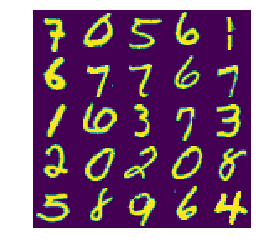

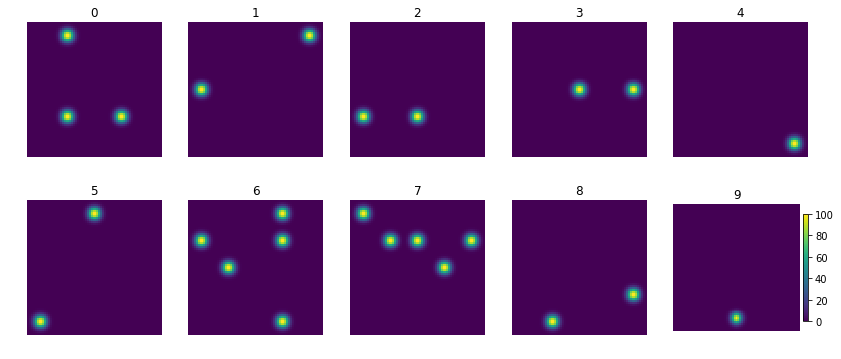

In [10]:
x1 =  x[0].view(-1,25,26,26)
y1 = x[1].view(-1,5,5)
X = [make_grid(x1[i,:,:,:].unsqueeze(1), nrow=5) for i in range(64)]
X = torch.stack(X)


Y = [get_label_map(x1[i,:,:,:],y1[i,:,:]) for i in range(64)]

Y = torch.stack(Y)

A = X.cpu().detach().numpy()

B = Y.cpu().detach().numpy()


plt.imshow(A[0,:,:,:].squeeze())
plt.axis('off')
plt.show()

f,axs = plt.subplots(2,5, figsize=(14,6))

for i,ax in enumerate(axs.flatten()):
    h = ax.imshow(B[0,i,:,:].squeeze())
    ax.set_title(i)
    ax.axis('off')
    
f.colorbar(h, fraction=0.04, pad=0.02)

plt.show()

In [2]:
class CanvasModelBig(nn.Module):
    def __init__(self ):
        super(CanvasModelBig, self).__init__()
        self.conv_bias = False
        
        self.encoder = self.conv_block()
        
    def conv_block(self):
        layers = [ 
        nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2, bias= self.conv_bias),
        nn.ReLU(True),
        nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2, bias= self.conv_bias),
        nn.ReLU(True),
        nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2, bias= self.conv_bias),
        nn.ReLU(True),
        nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2, bias= self.conv_bias),
        nn.ReLU(True),
        nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0, bias= self.conv_bias),
        nn.ReLU(True),
        nn.Conv2d(512, 10, kernel_size=1, stride=1, padding=0, bias= self.conv_bias),
        ]

        return nn.Sequential(*layers)
    
    def forward(self, x):
        h = self.encoder(x)
        return h
          
model = CanvasModelBig()
model.cuda()

summary(model, (1,65, 65))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,600
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]         204,800
              ReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 256, 32, 32]         819,200
              ReLU-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 512, 32, 32]       3,276,800
              ReLU-8          [-1, 512, 32, 32]               0
            Conv2d-9          [-1, 512, 32, 32]         262,144
             ReLU-10          [-1, 512, 32, 32]               0
           Conv2d-11           [-1, 10, 32, 32]           5,120
Total params: 4,569,664
Trainable params: 4,569,664
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forw

Epoch 0/59
----------
train Loss: 2.9582, Acc: 0.0990


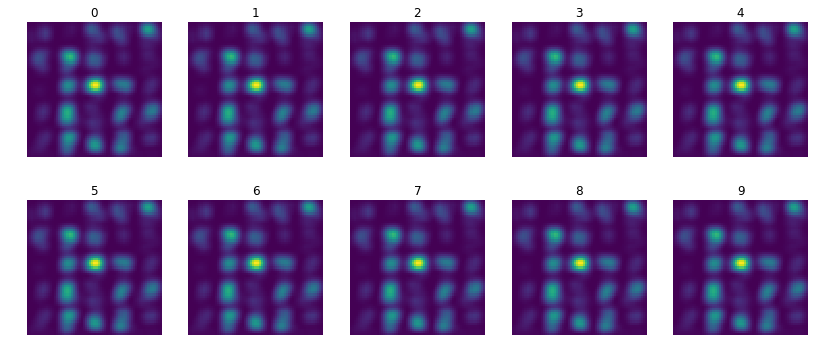

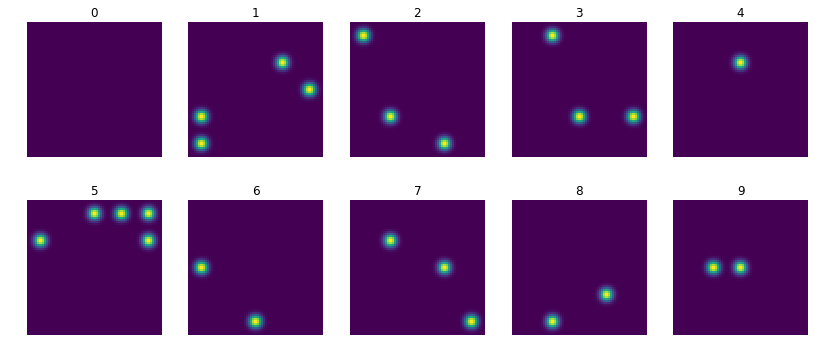

test Loss: 2.7845, Acc: 0.0980

Epoch 1/59
----------
train Loss: 2.8324, Acc: 0.0969


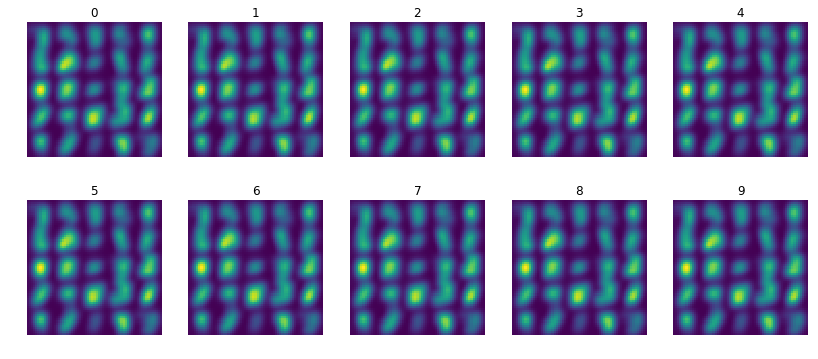

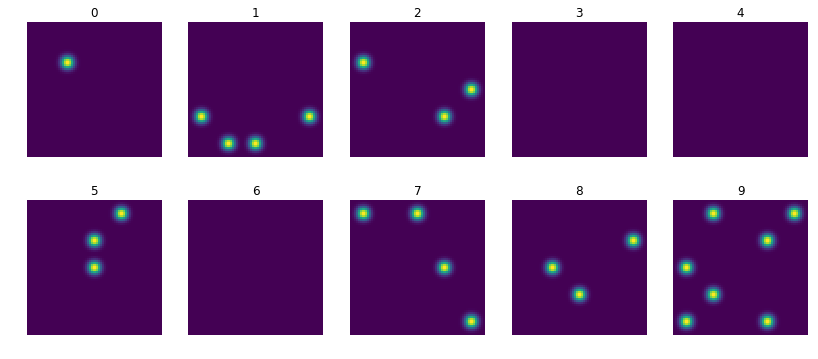

test Loss: 2.6569, Acc: 0.1381

Epoch 2/59
----------
train Loss: 2.6654, Acc: 0.1463


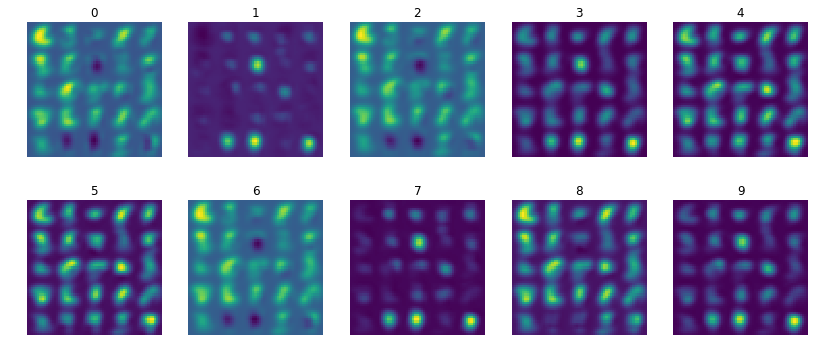

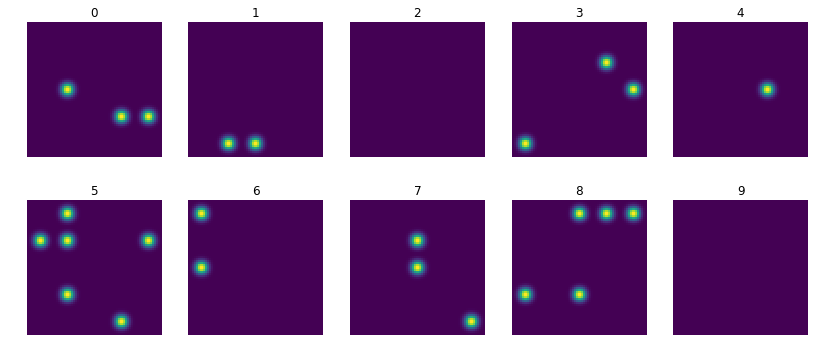

test Loss: 2.4762, Acc: 0.1875

Epoch 3/59
----------
train Loss: 2.3913, Acc: 0.2898


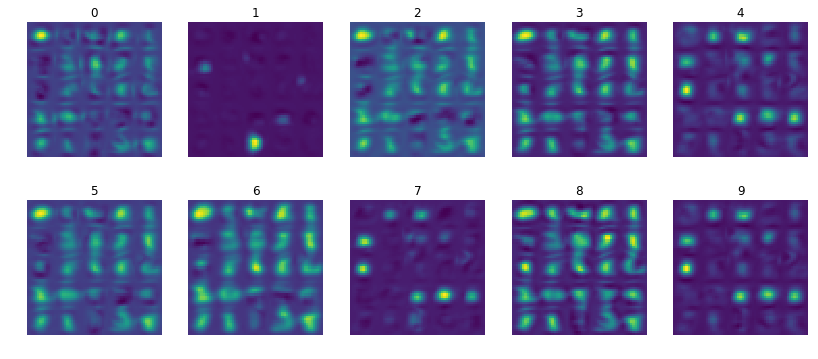

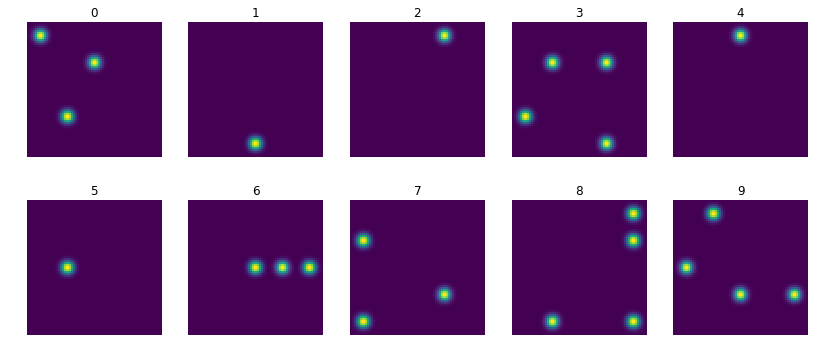

test Loss: 2.1687, Acc: 0.3883

Epoch 4/59
----------
train Loss: 2.1212, Acc: 0.4299


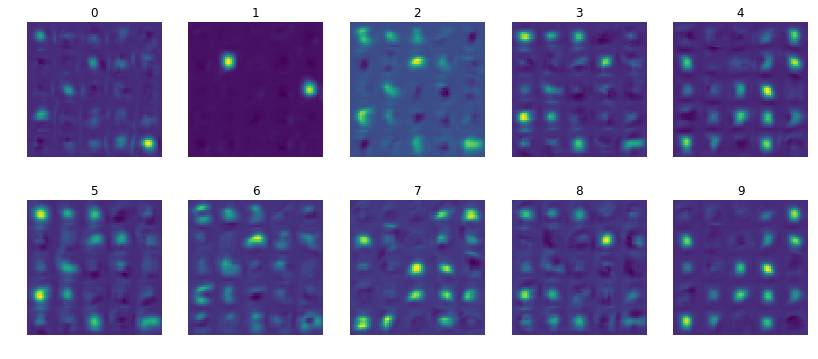

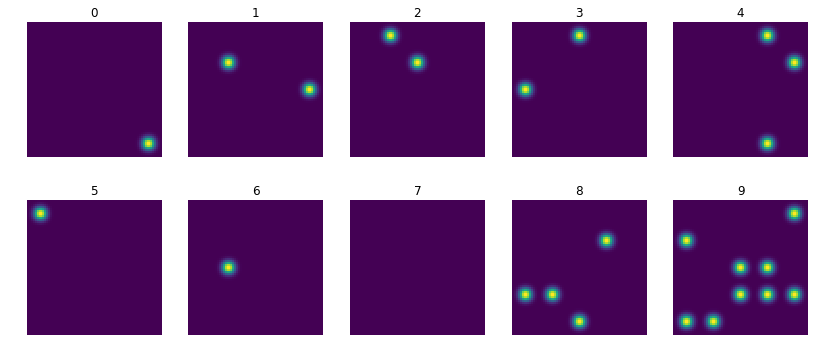

test Loss: 1.9027, Acc: 0.5071

Epoch 5/59
----------
train Loss: 1.7929, Acc: 0.6164


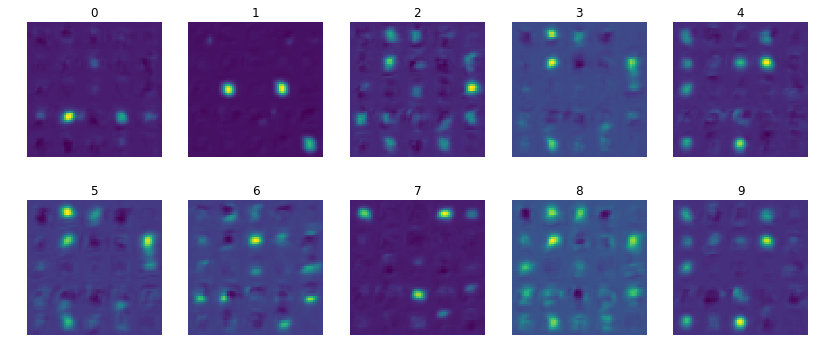

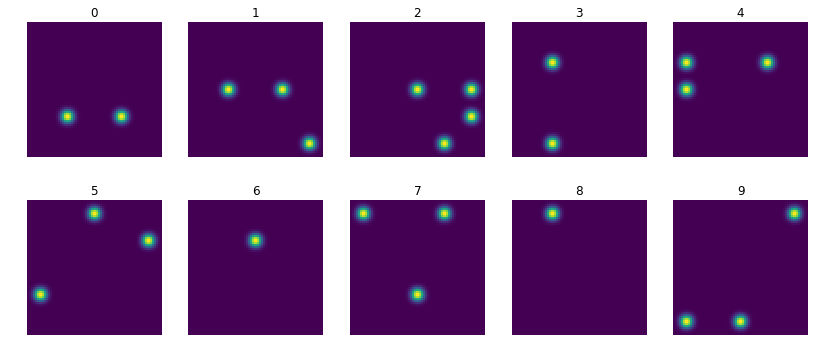

test Loss: 1.5198, Acc: 0.7055

Epoch 6/59
----------
train Loss: 1.4152, Acc: 0.7674


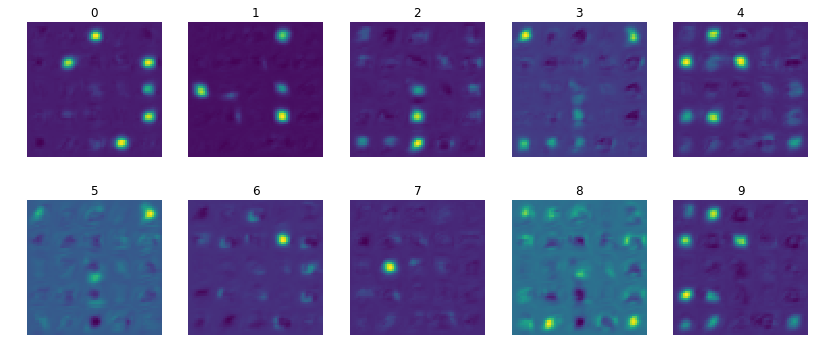

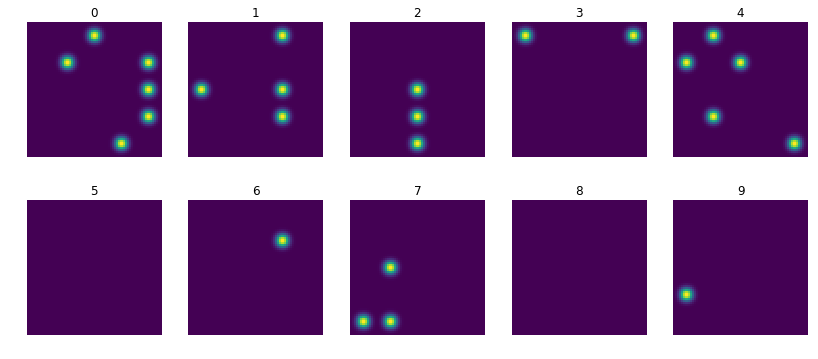

test Loss: 1.1935, Acc: 0.8356

Epoch 7/59
----------
train Loss: 1.0953, Acc: 0.8627


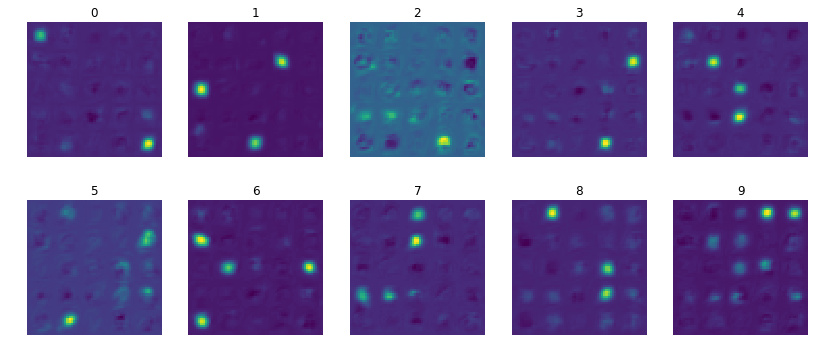

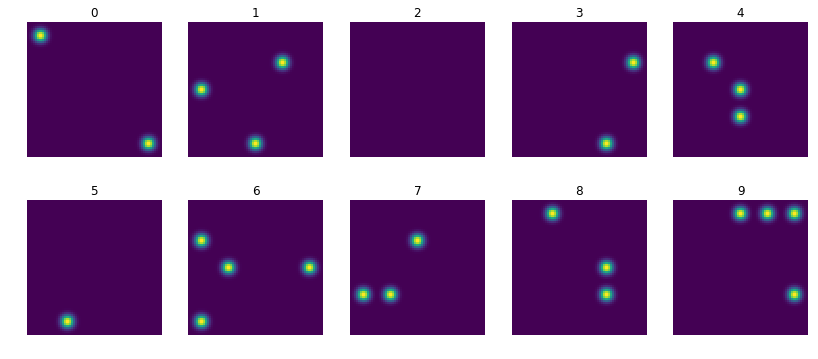

test Loss: 0.8481, Acc: 0.9174

Epoch 8/59
----------
train Loss: 0.7812, Acc: 0.9240


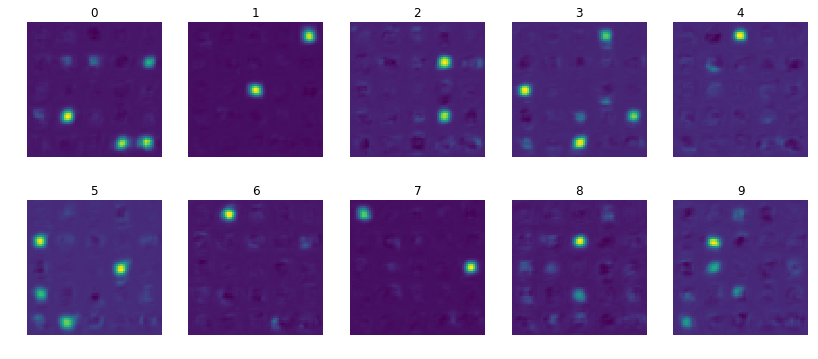

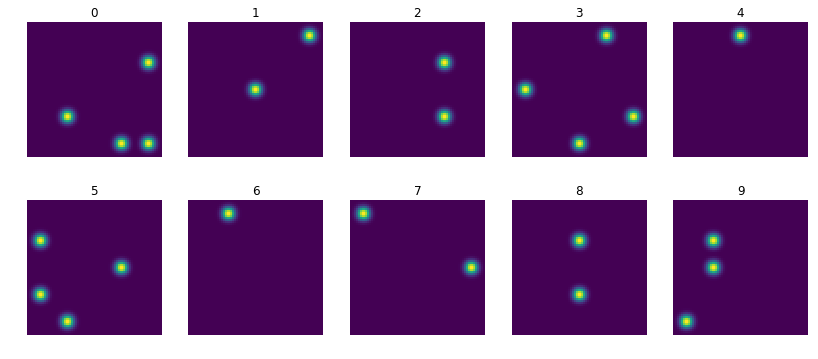

test Loss: 0.6273, Acc: 0.9478

Epoch 9/59
----------
train Loss: 0.6346, Acc: 0.9407


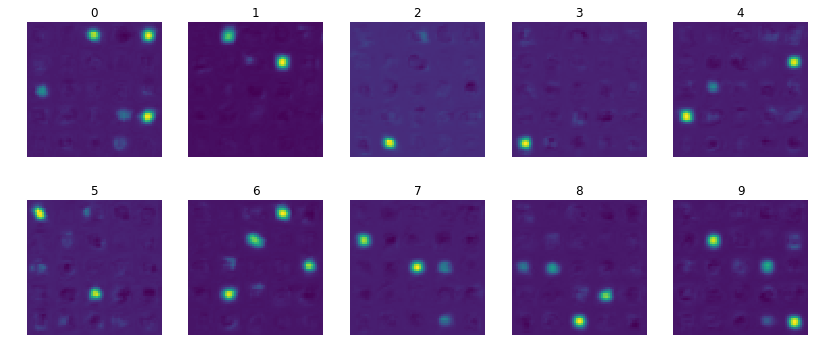

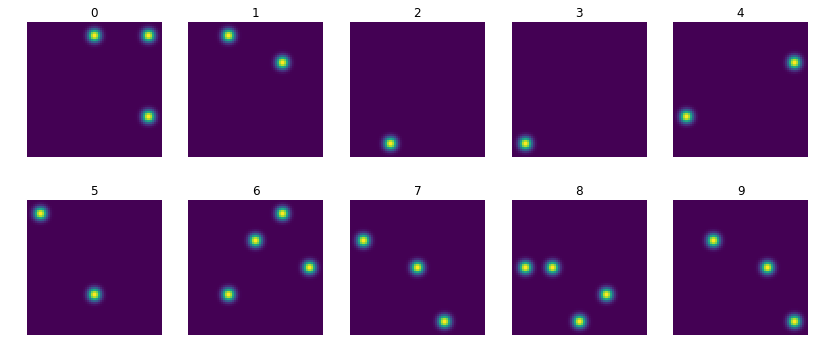

test Loss: 0.5382, Acc: 0.9547

Epoch 10/59
----------
train Loss: 0.5356, Acc: 0.9519


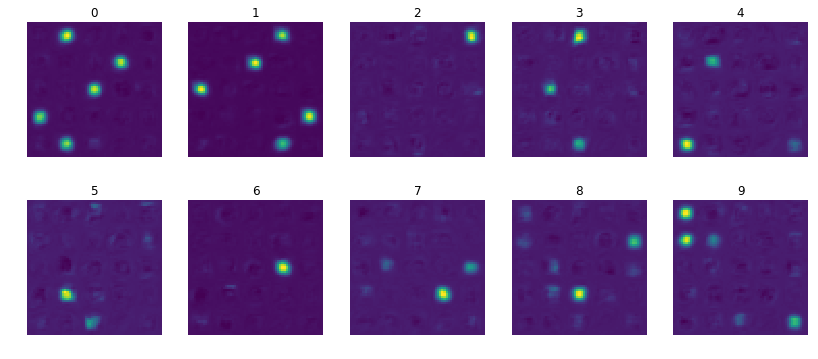

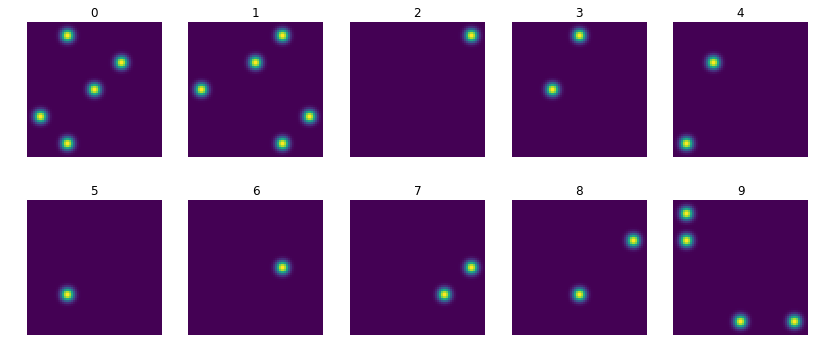

test Loss: 0.4607, Acc: 0.9619

Epoch 11/59
----------
train Loss: 0.4835, Acc: 0.9564


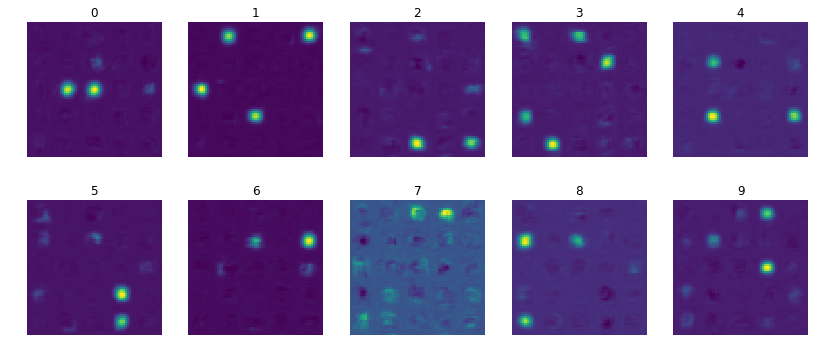

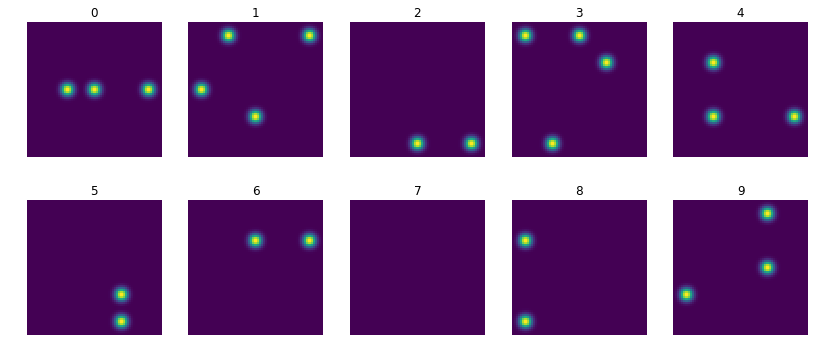

test Loss: 0.4141, Acc: 0.9674

Epoch 12/59
----------
train Loss: 0.4333, Acc: 0.9614


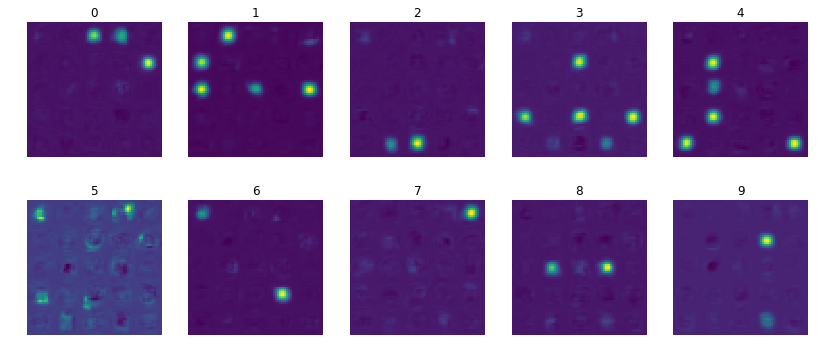

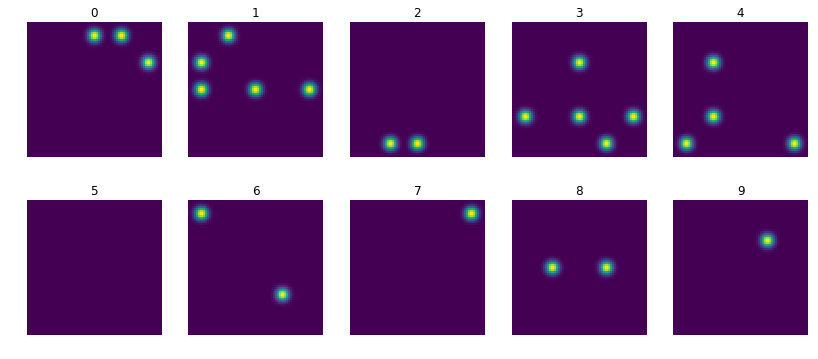

test Loss: 0.3756, Acc: 0.9699

Epoch 13/59
----------
train Loss: 0.3967, Acc: 0.9652


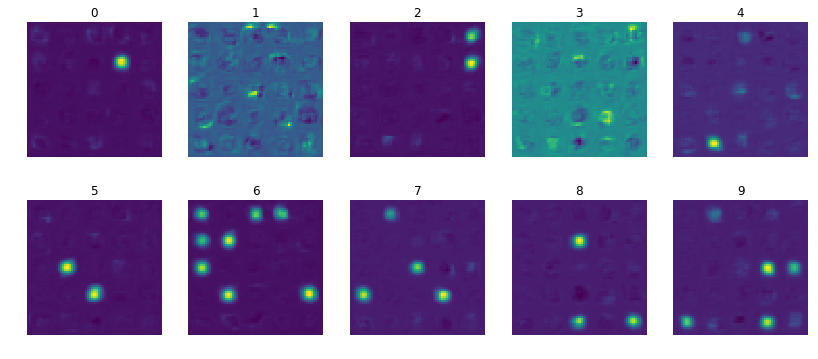

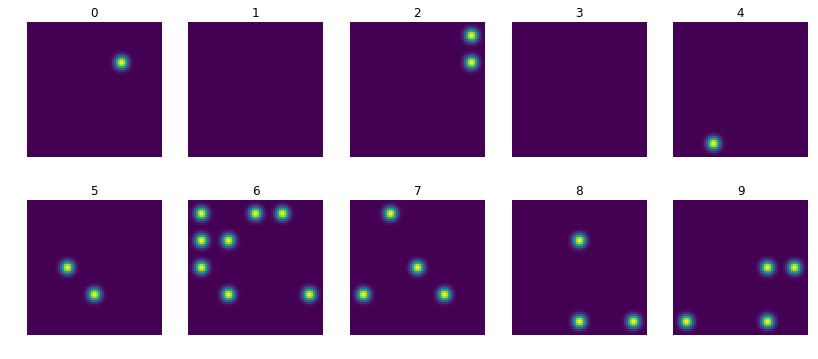

test Loss: 0.3459, Acc: 0.9731

Epoch 14/59
----------
train Loss: 0.3712, Acc: 0.9673


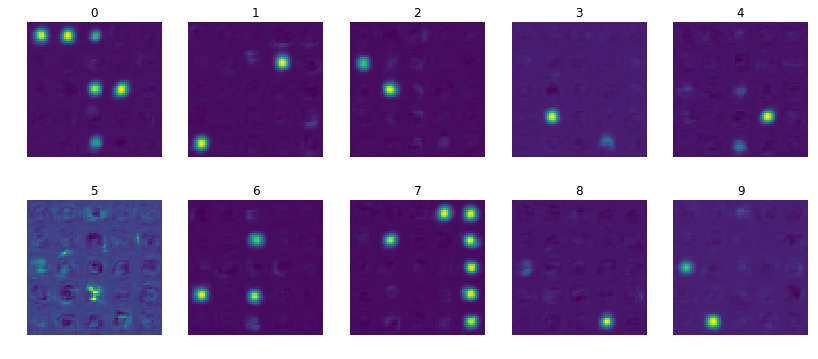

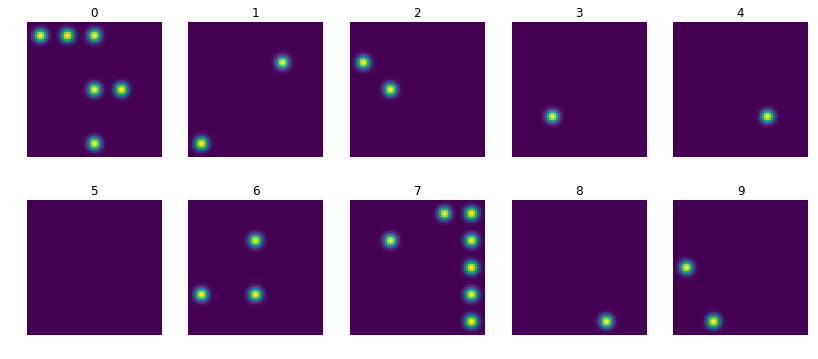

test Loss: 0.3266, Acc: 0.9744

Epoch 15/59
----------
train Loss: 0.3470, Acc: 0.9696


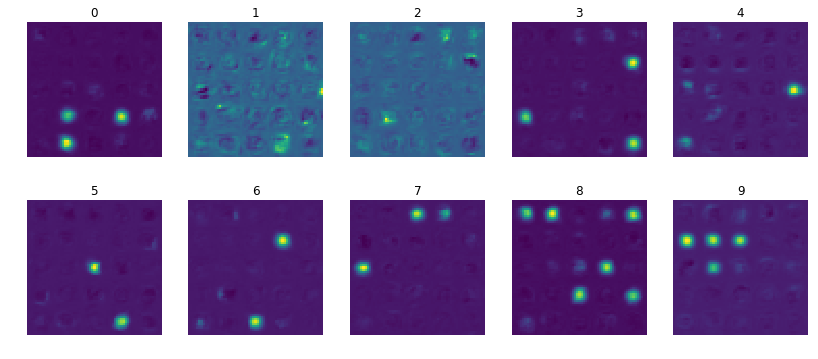

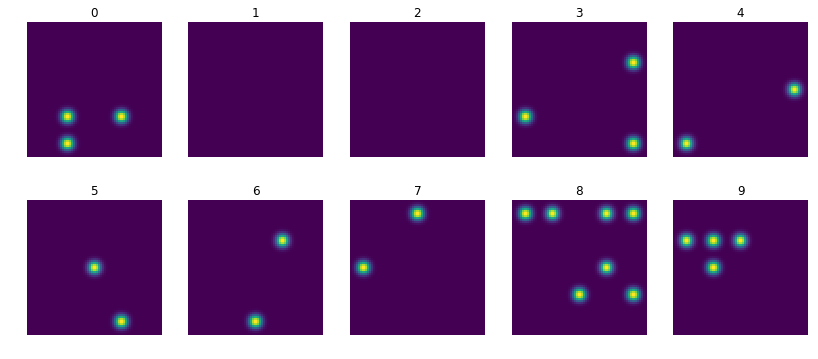

test Loss: 0.3127, Acc: 0.9757

Epoch 16/59
----------
train Loss: 0.3281, Acc: 0.9717


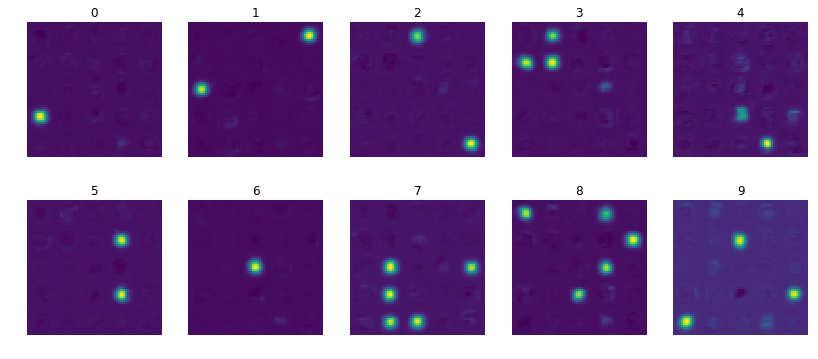

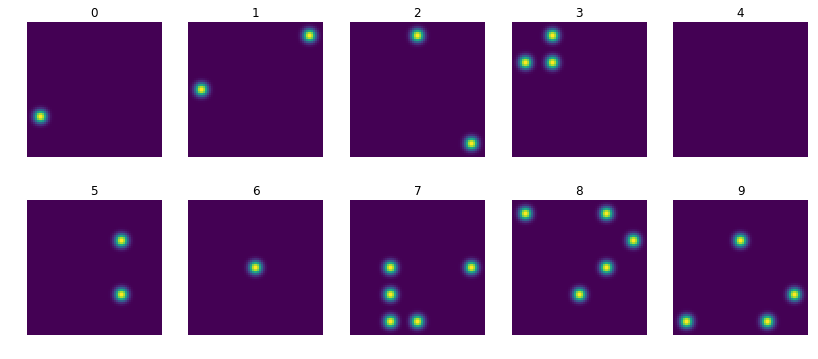

test Loss: 0.2867, Acc: 0.9767

Epoch 17/59
----------
train Loss: 0.3077, Acc: 0.9736


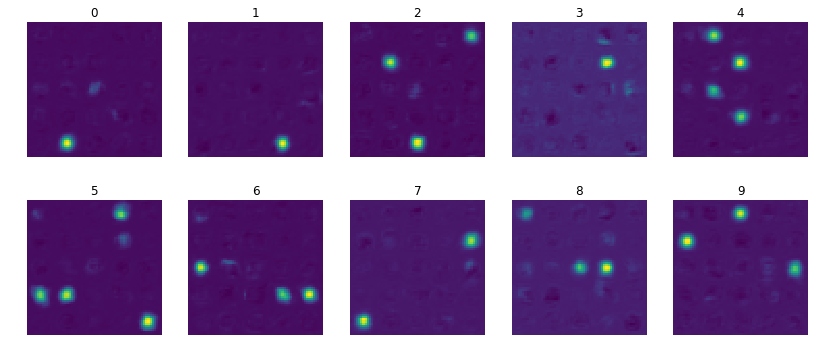

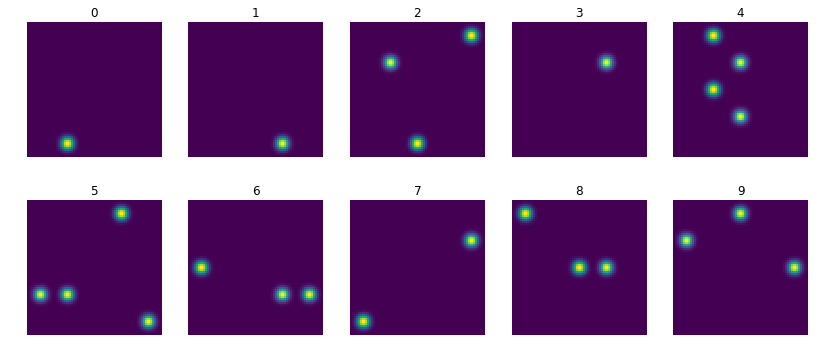

test Loss: 0.2743, Acc: 0.9777

Epoch 18/59
----------
train Loss: 0.2984, Acc: 0.9743


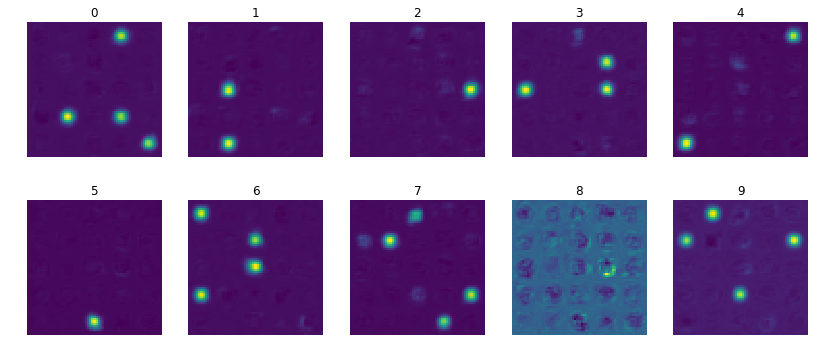

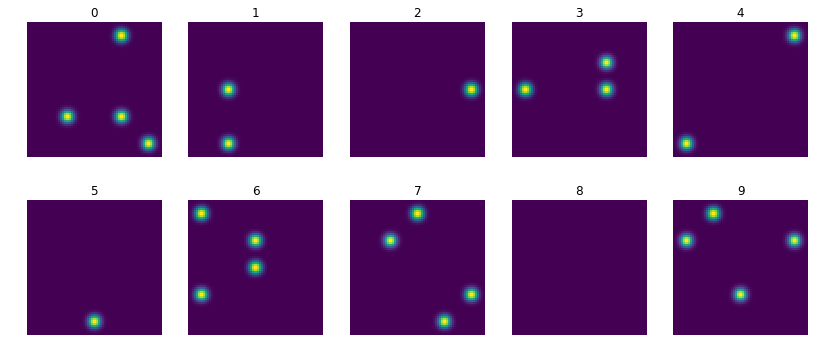

test Loss: 0.2766, Acc: 0.9781

Epoch 19/59
----------
train Loss: 0.2841, Acc: 0.9746


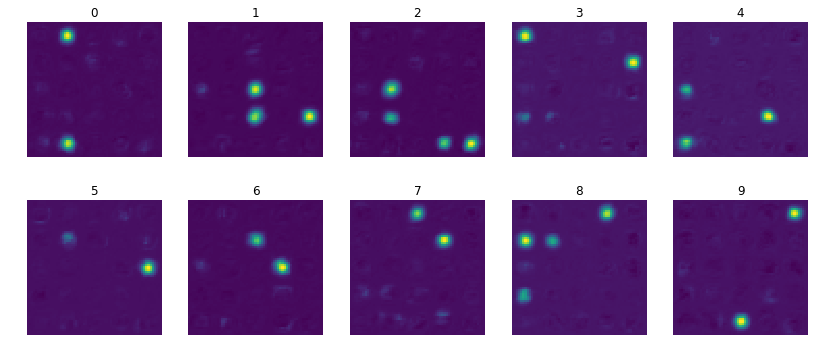

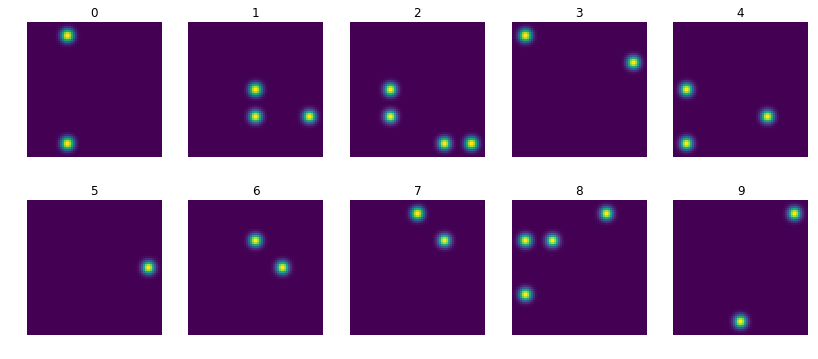

test Loss: 0.2522, Acc: 0.9792

Epoch 20/59
----------
train Loss: 0.2683, Acc: 0.9770


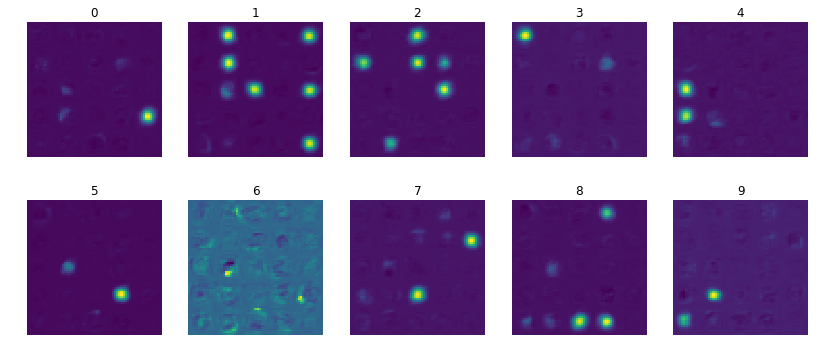

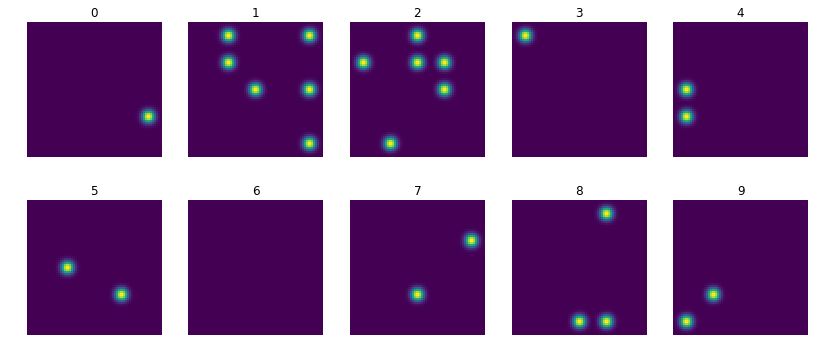

test Loss: 0.2303, Acc: 0.9820

Epoch 21/59
----------
train Loss: 0.2546, Acc: 0.9784


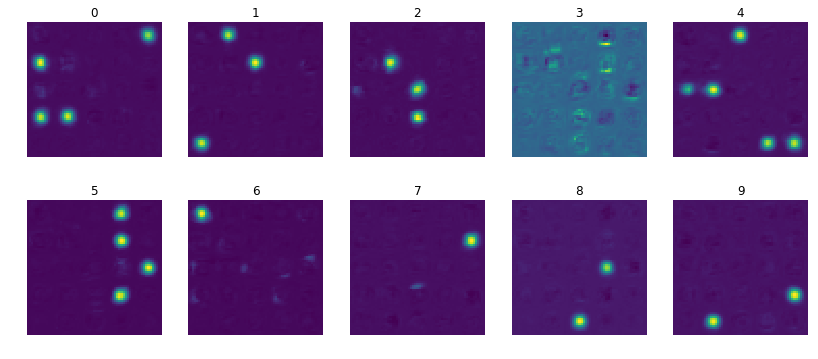

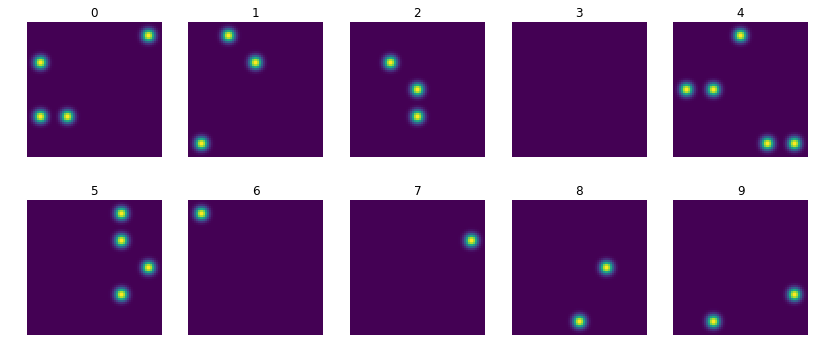

test Loss: 0.2218, Acc: 0.9832

Epoch 22/59
----------
train Loss: 0.2434, Acc: 0.9795


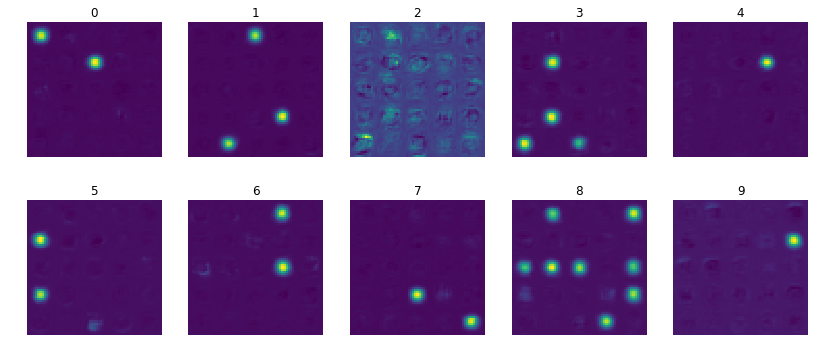

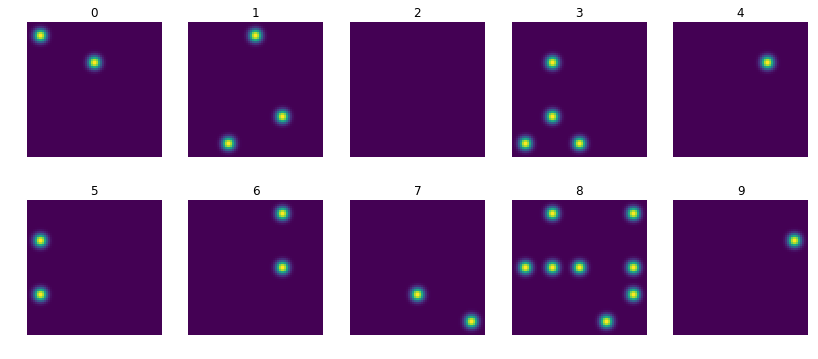

test Loss: 0.2231, Acc: 0.9818

Epoch 23/59
----------
train Loss: 0.2337, Acc: 0.9803


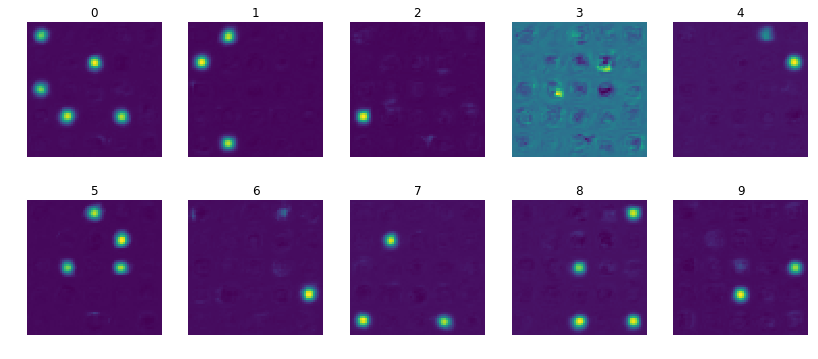

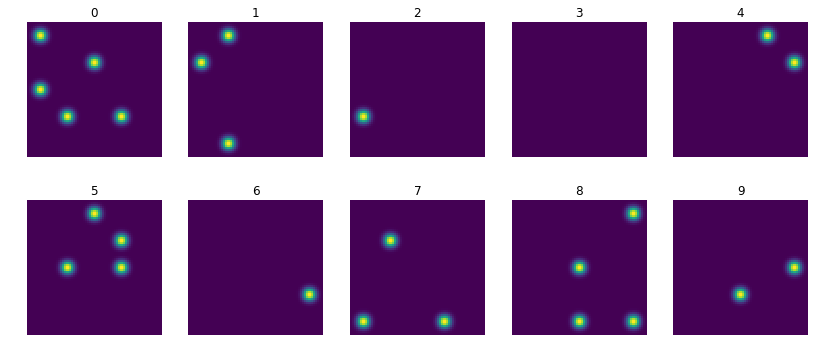

test Loss: 0.2090, Acc: 0.9839

Epoch 24/59
----------
train Loss: 0.2252, Acc: 0.9812


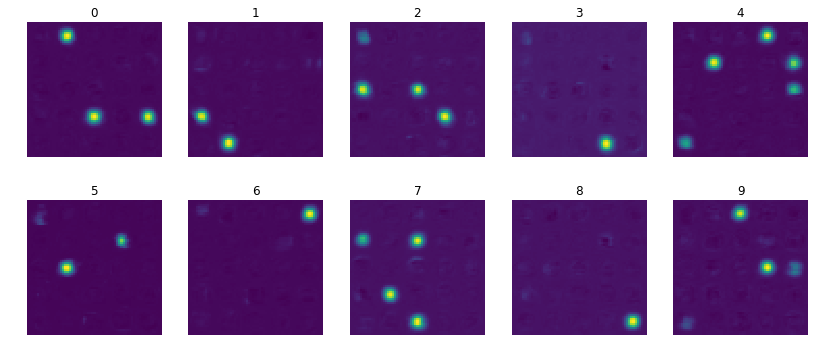

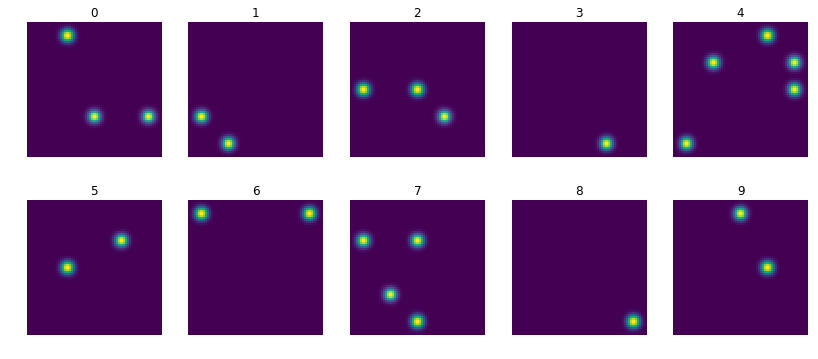

test Loss: 0.2090, Acc: 0.9847

Epoch 25/59
----------
train Loss: 0.2175, Acc: 0.9820


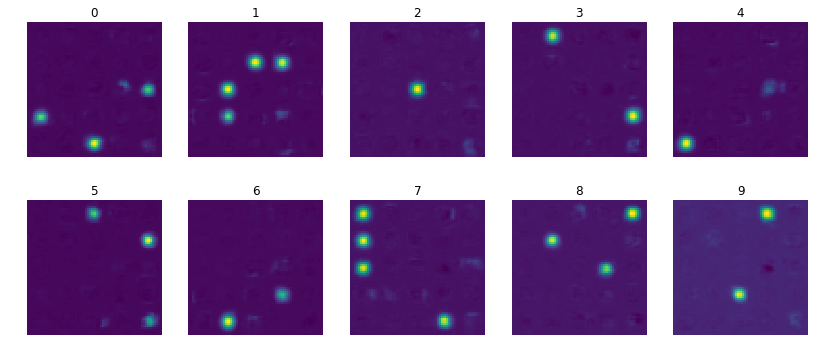

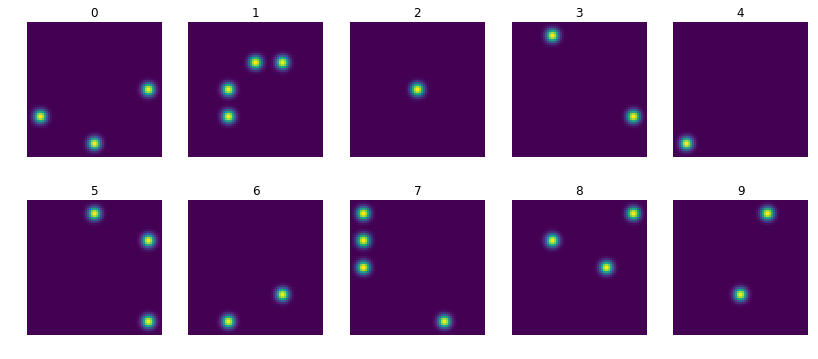

test Loss: 0.1886, Acc: 0.9855

Epoch 26/59
----------
train Loss: 0.2042, Acc: 0.9831


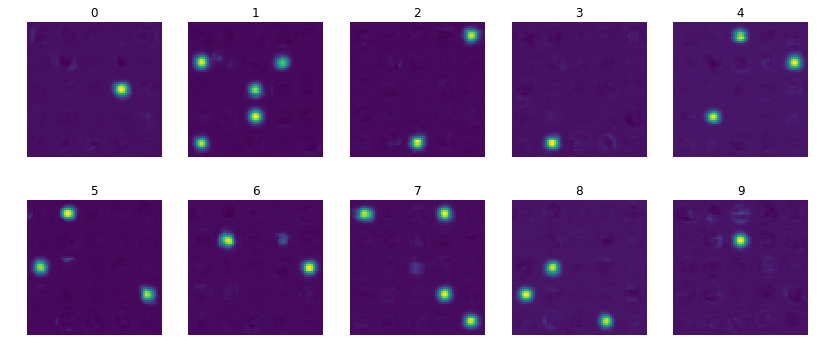

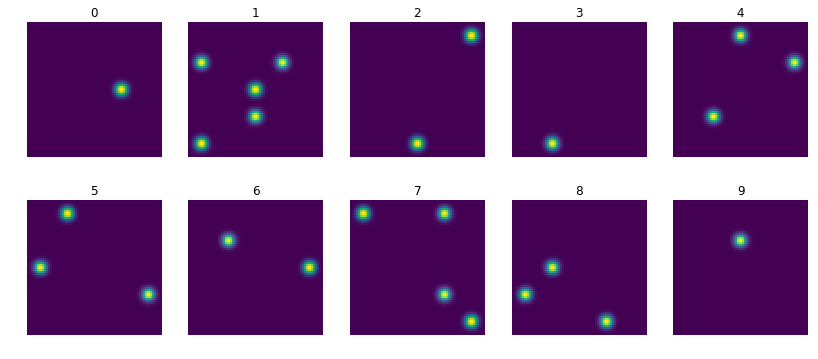

test Loss: 0.1867, Acc: 0.9859

Epoch 27/59
----------
train Loss: 0.1988, Acc: 0.9841


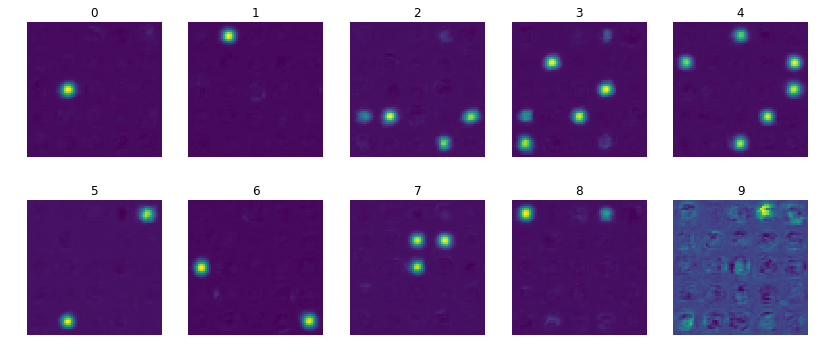

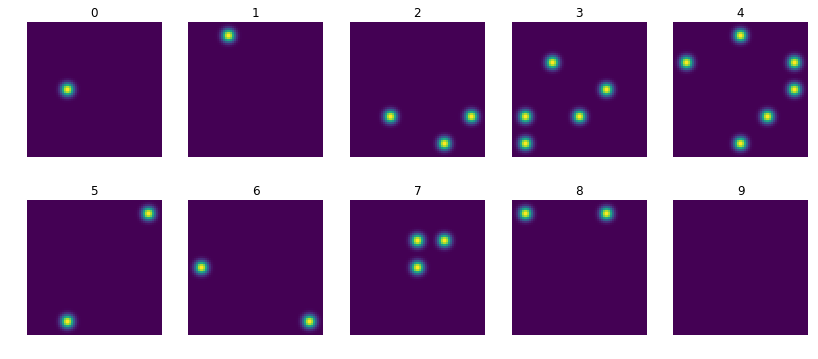

test Loss: 0.1753, Acc: 0.9868

Epoch 28/59
----------
train Loss: 0.1897, Acc: 0.9847


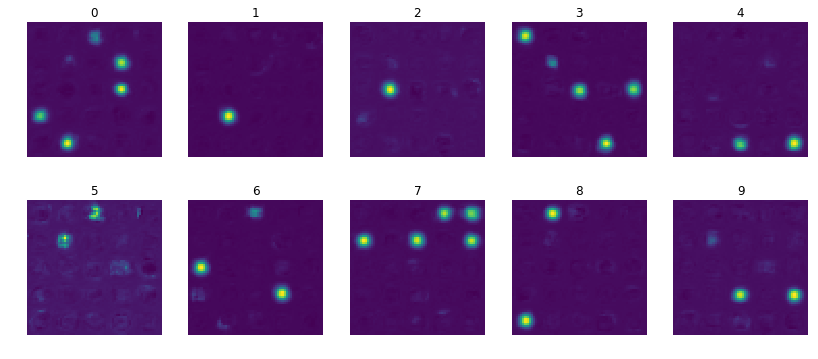

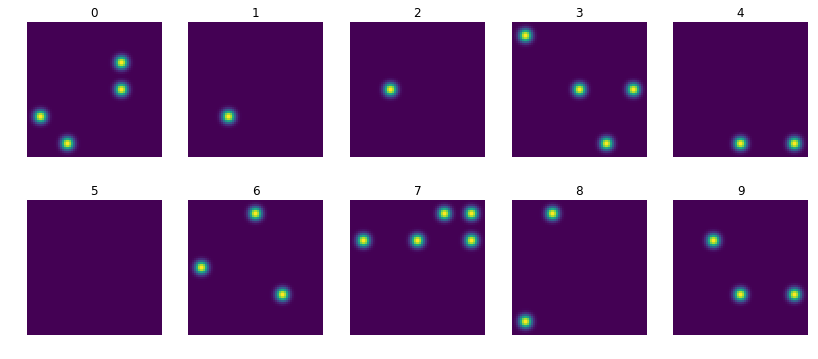

test Loss: 0.1715, Acc: 0.9880

Epoch 29/59
----------
train Loss: 0.1846, Acc: 0.9853


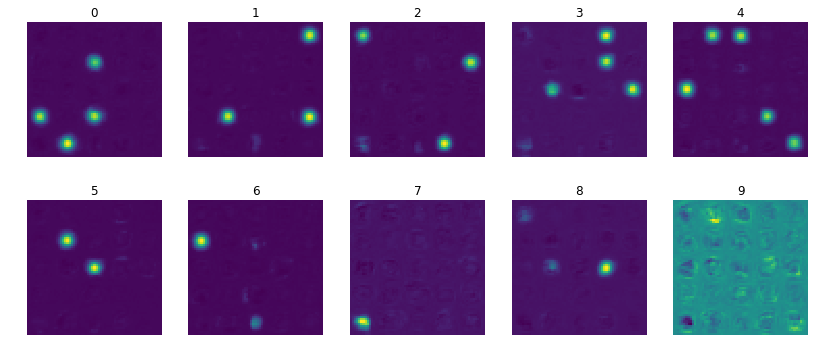

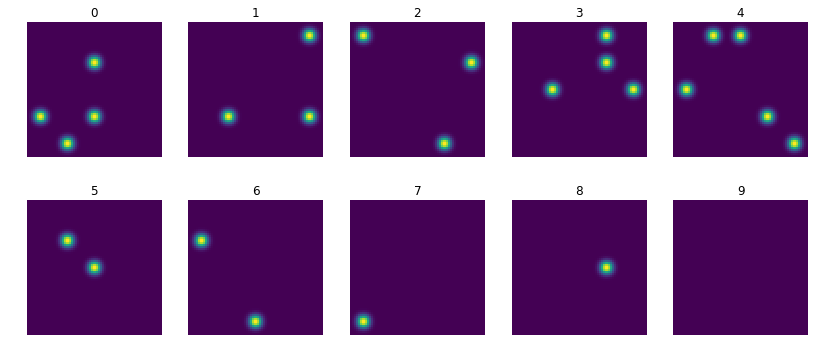

test Loss: 0.1680, Acc: 0.9866

Epoch 30/59
----------
train Loss: 0.1777, Acc: 0.9857


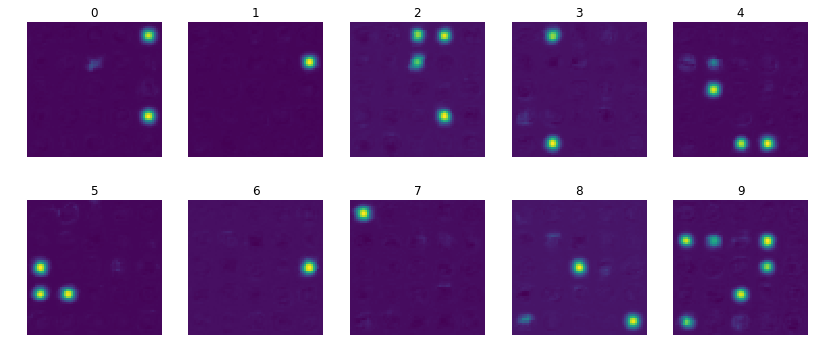

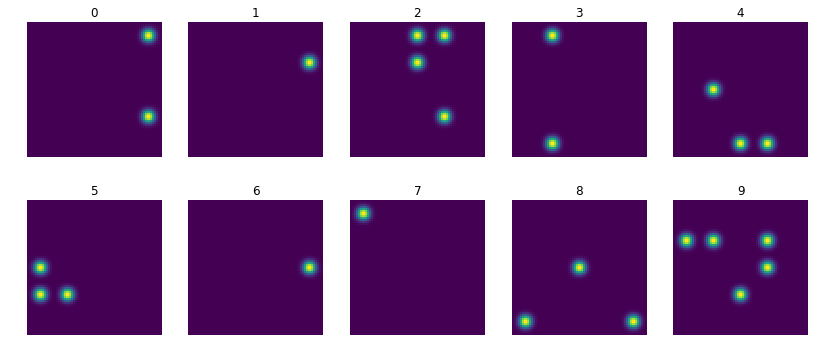

test Loss: 0.1629, Acc: 0.9884

Epoch 31/59
----------
train Loss: 0.1744, Acc: 0.9866


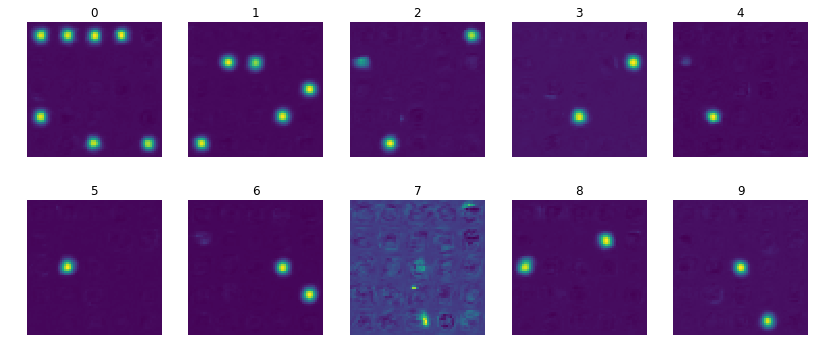

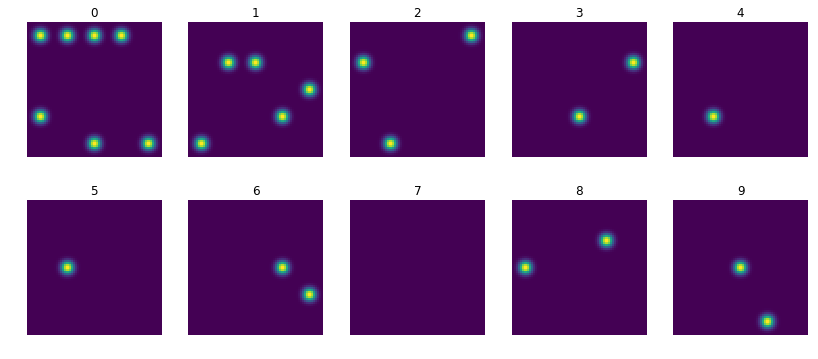

test Loss: 0.1550, Acc: 0.9878

Epoch 32/59
----------
train Loss: 0.1669, Acc: 0.9872


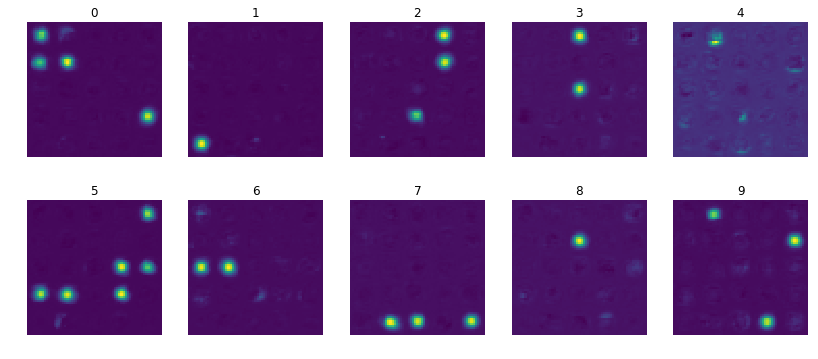

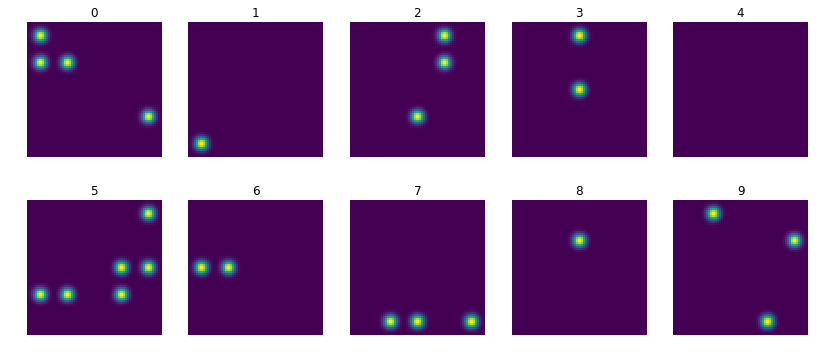

test Loss: 0.1618, Acc: 0.9888

Epoch 33/59
----------
train Loss: 0.1644, Acc: 0.9876


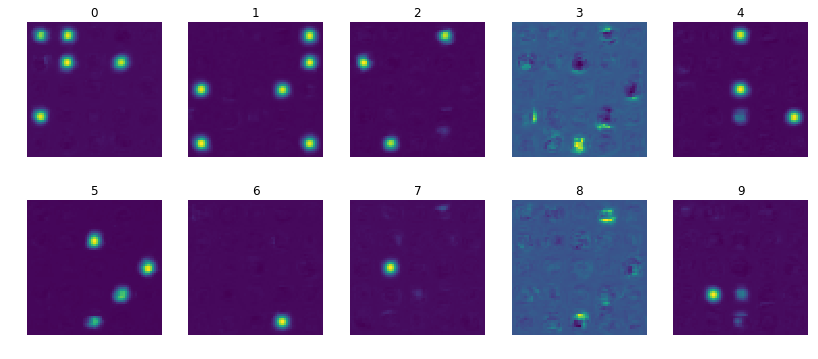

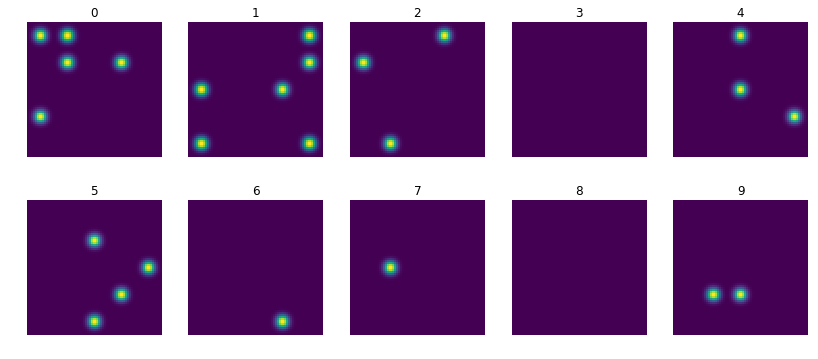

test Loss: 0.1466, Acc: 0.9898

Epoch 34/59
----------
train Loss: 0.1572, Acc: 0.9880


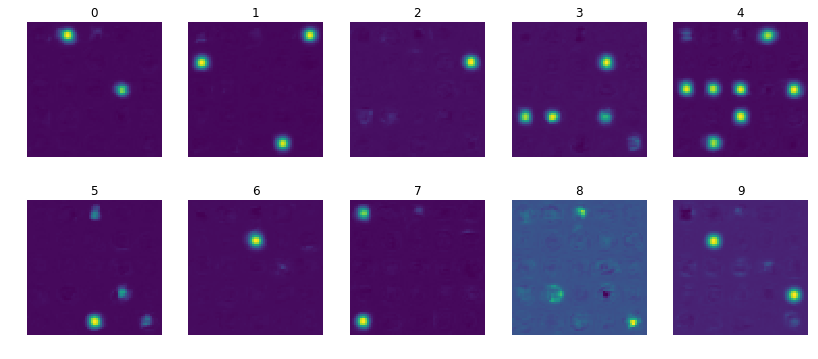

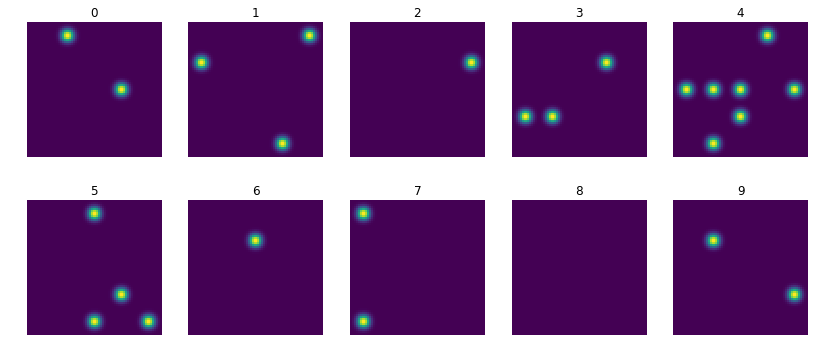

test Loss: 0.1407, Acc: 0.9898

Epoch 35/59
----------
train Loss: 0.1552, Acc: 0.9885


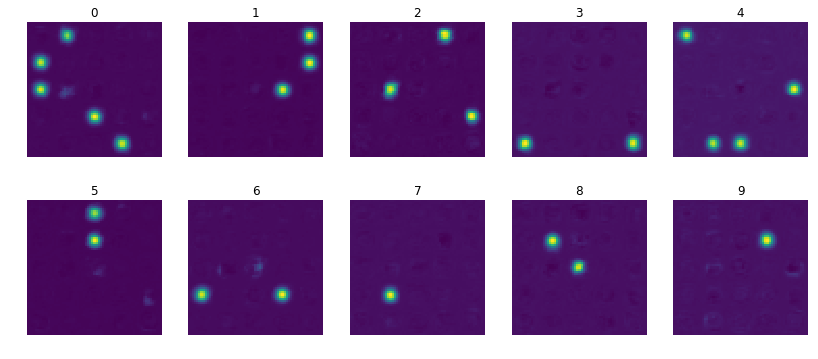

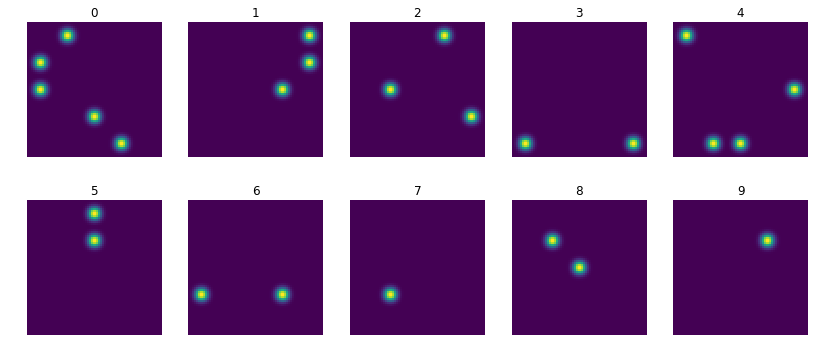

test Loss: 0.1498, Acc: 0.9889

Epoch 36/59
----------
train Loss: 0.1485, Acc: 0.9887


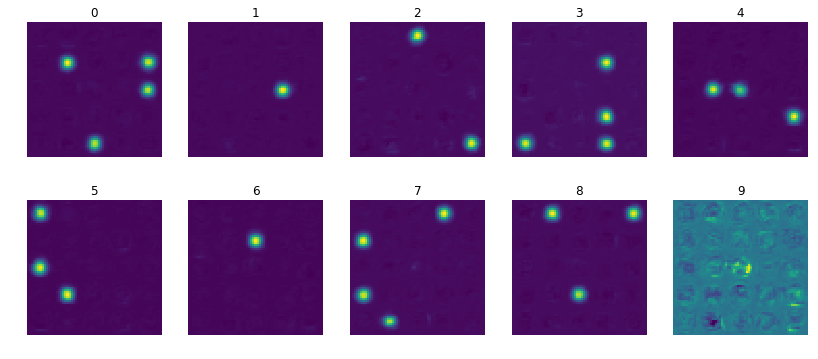

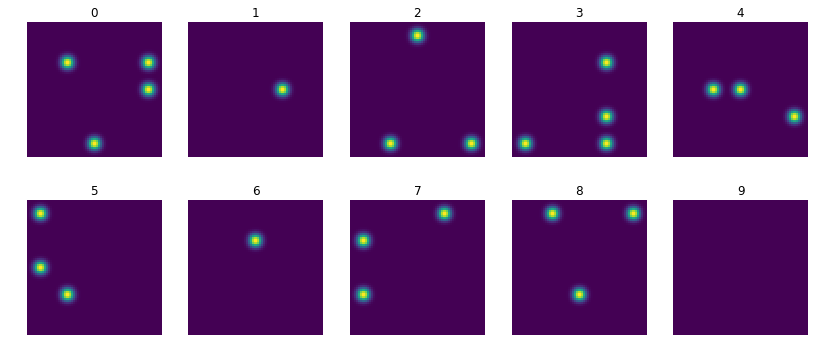

test Loss: 0.1385, Acc: 0.9889

Epoch 37/59
----------
train Loss: 0.1427, Acc: 0.9891


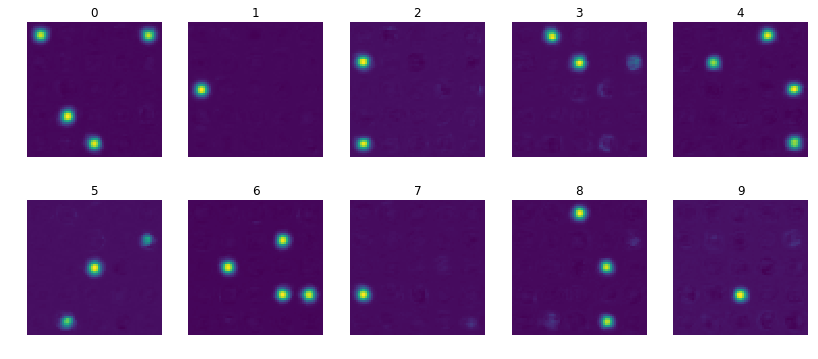

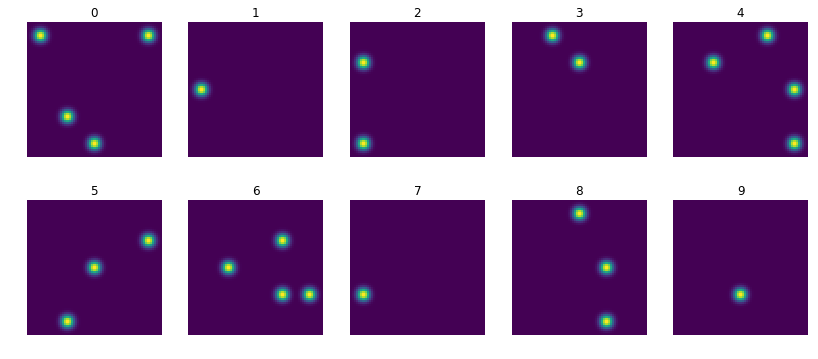

test Loss: 0.1332, Acc: 0.9894

Epoch 38/59
----------
train Loss: 0.1424, Acc: 0.9892


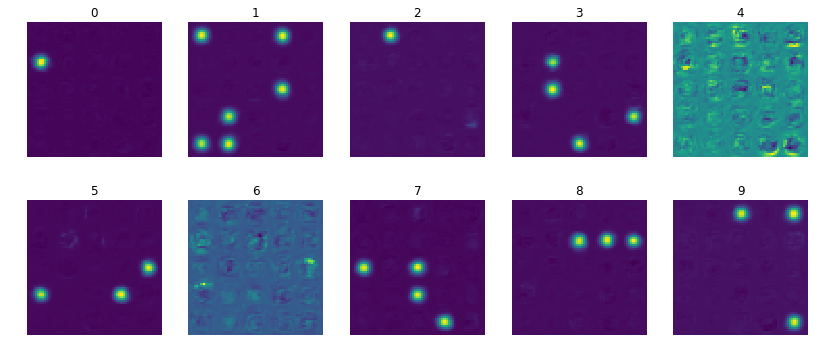

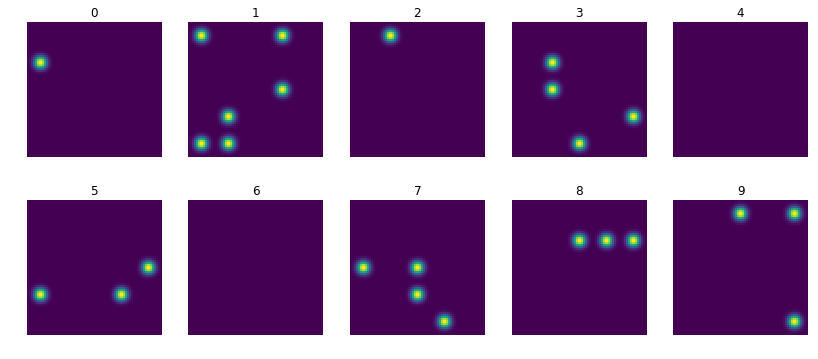

test Loss: 0.1329, Acc: 0.9905

Epoch 39/59
----------
train Loss: 0.1391, Acc: 0.9894


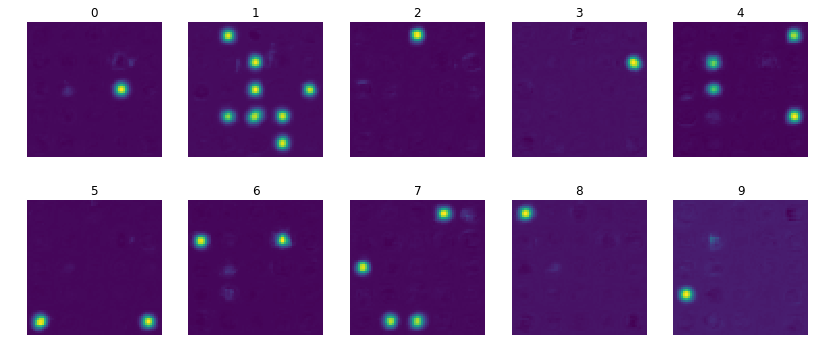

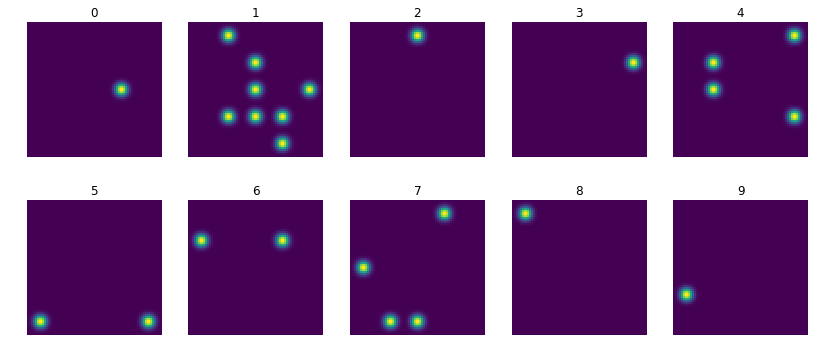

test Loss: 0.1311, Acc: 0.9898

Epoch 40/59
----------
train Loss: 0.1344, Acc: 0.9903


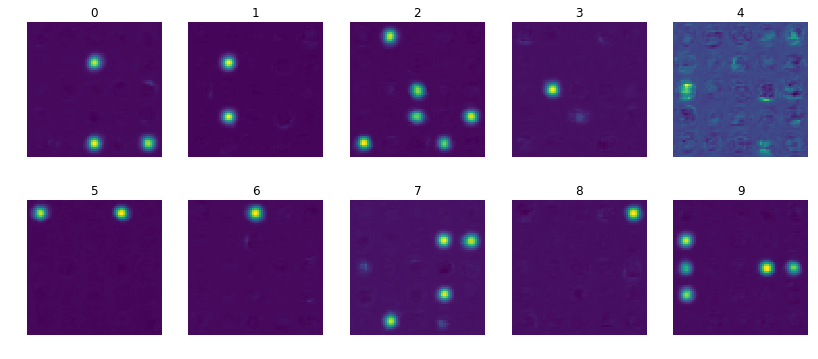

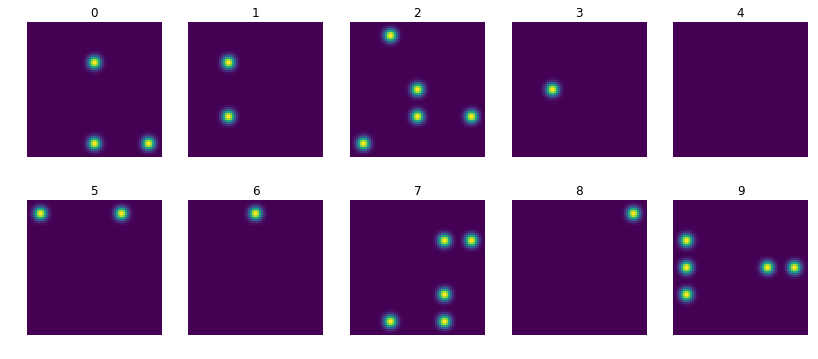

test Loss: 0.1293, Acc: 0.9903

Epoch 41/59
----------
train Loss: 0.1329, Acc: 0.9901


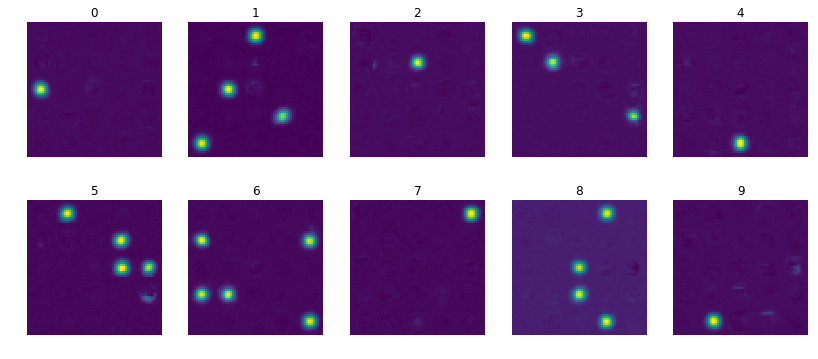

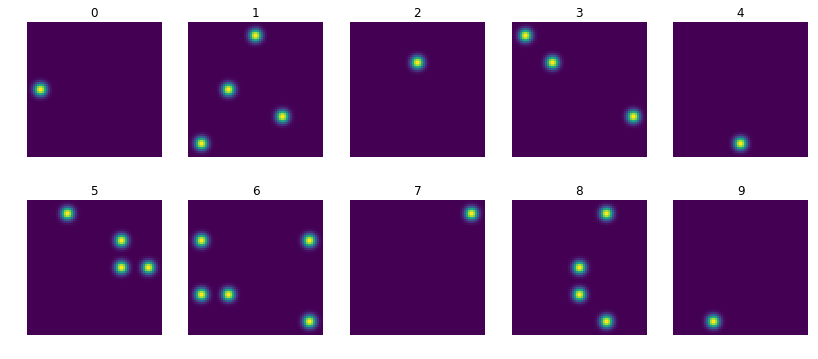

test Loss: 0.1259, Acc: 0.9901

Epoch 42/59
----------
train Loss: 0.1298, Acc: 0.9906


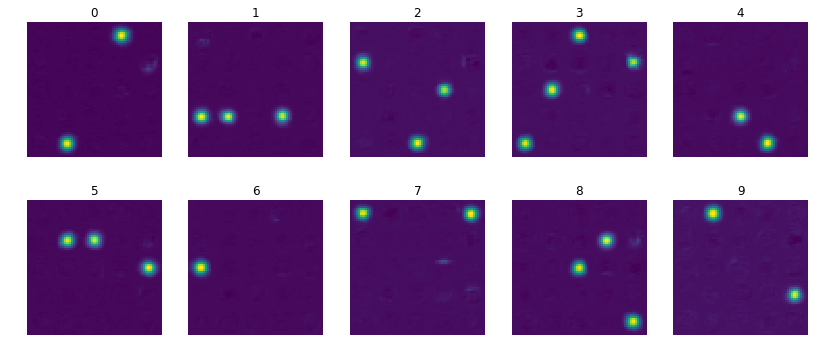

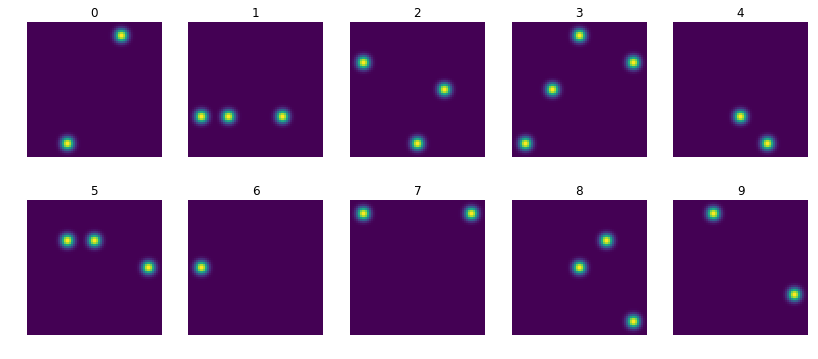

test Loss: 0.1192, Acc: 0.9915

Epoch 43/59
----------
train Loss: 0.1261, Acc: 0.9911


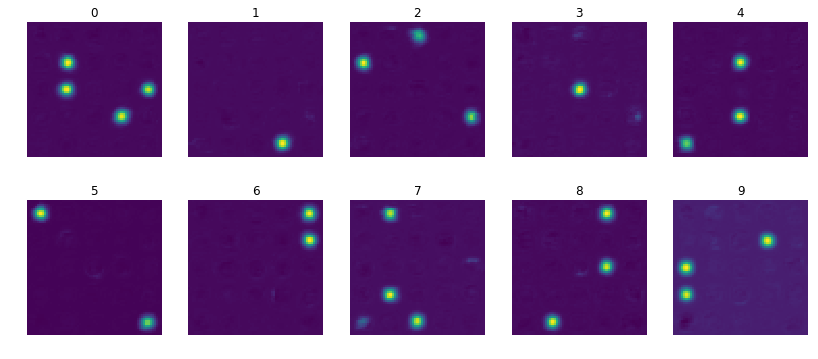

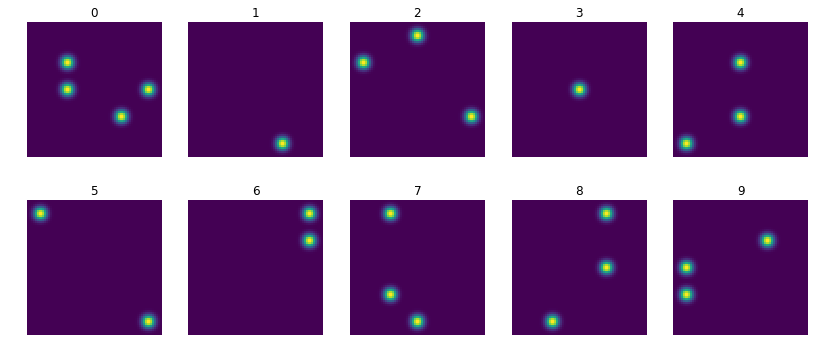

test Loss: 0.1169, Acc: 0.9918

Epoch 44/59
----------
train Loss: 0.1260, Acc: 0.9910


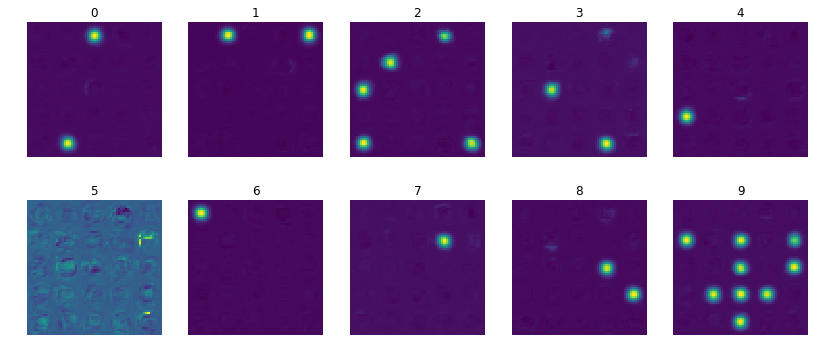

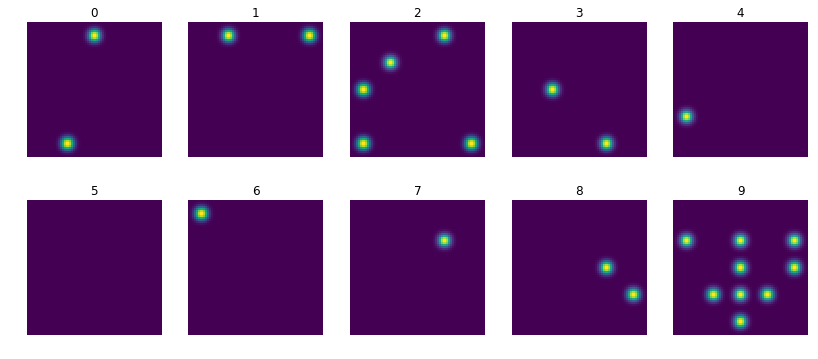

test Loss: 0.1234, Acc: 0.9898

Epoch 45/59
----------
train Loss: 0.1223, Acc: 0.9916


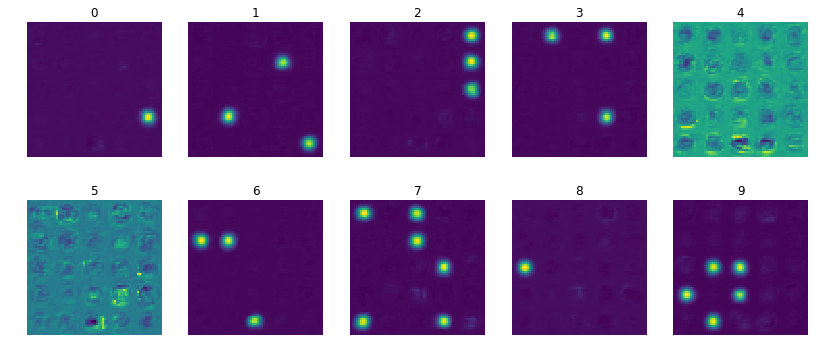

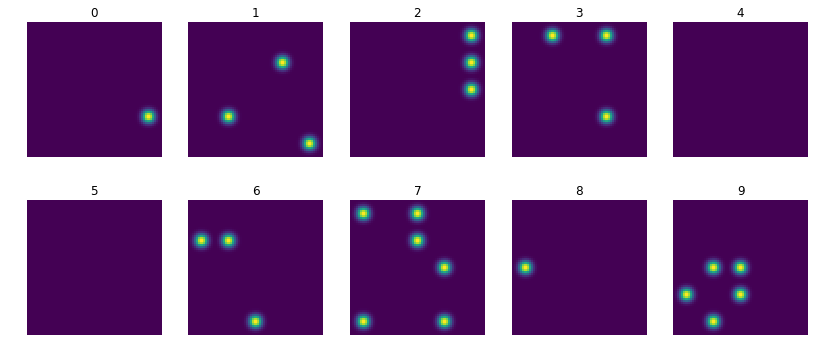

test Loss: 0.1202, Acc: 0.9911

Epoch 46/59
----------
train Loss: 0.1249, Acc: 0.9914


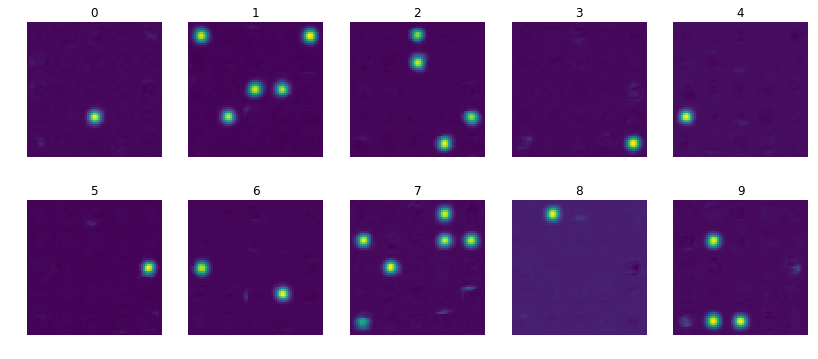

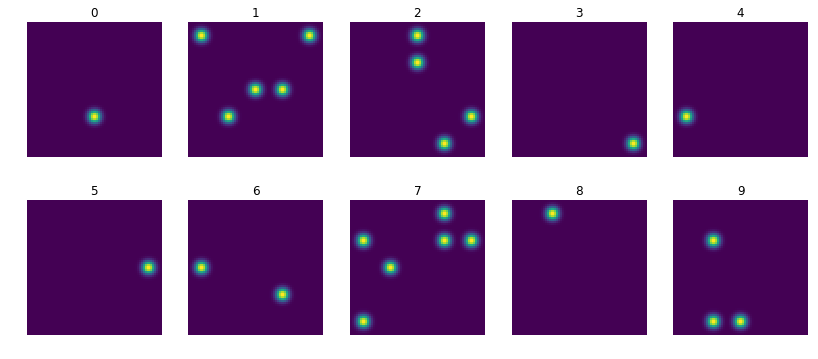

test Loss: 0.1233, Acc: 0.9909

Epoch 47/59
----------
train Loss: 0.1189, Acc: 0.9917


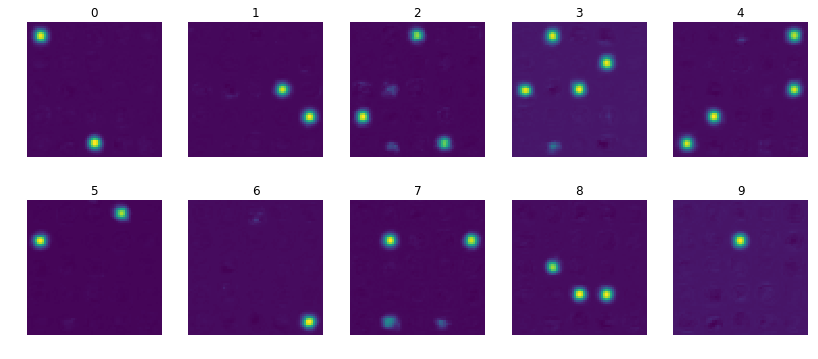

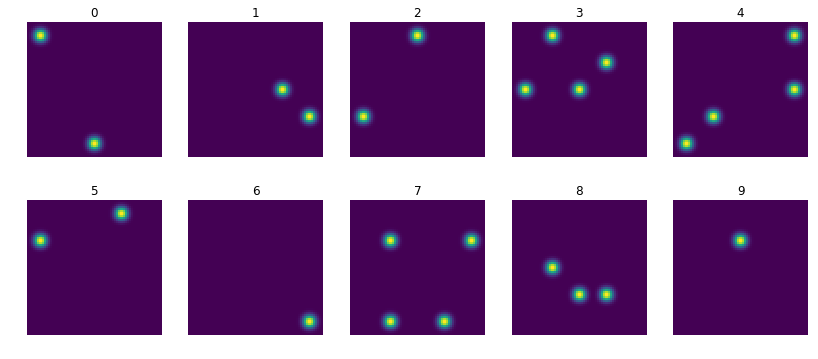

test Loss: 0.1123, Acc: 0.9916

Epoch 48/59
----------
train Loss: 0.1152, Acc: 0.9920


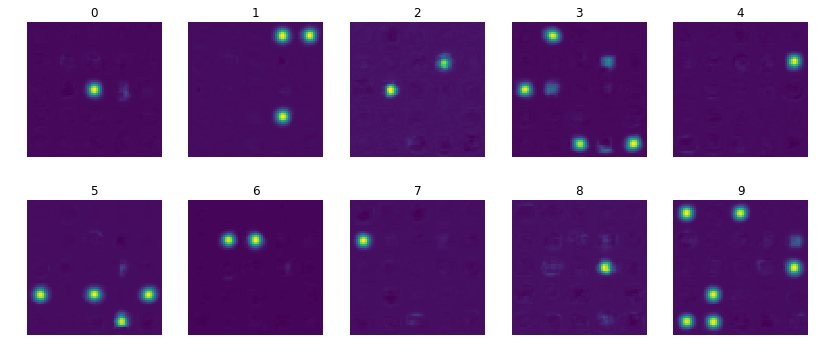

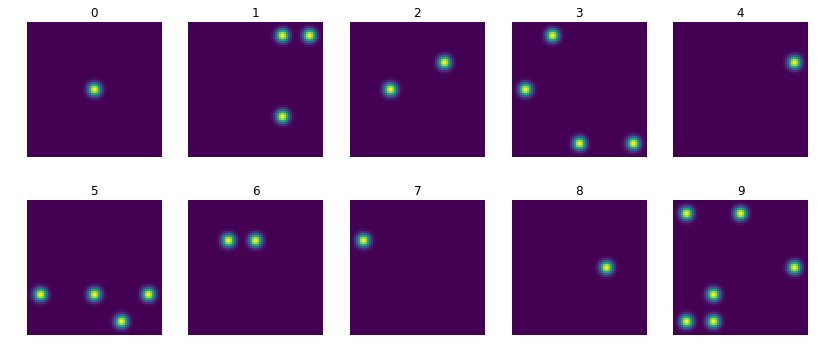

test Loss: 0.1070, Acc: 0.9917

Epoch 49/59
----------
train Loss: 0.1123, Acc: 0.9922


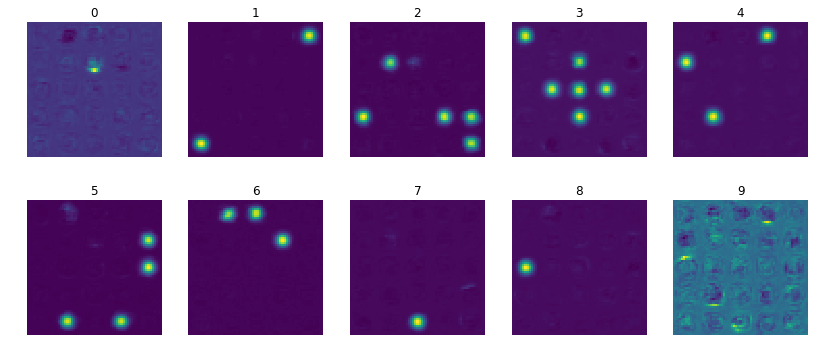

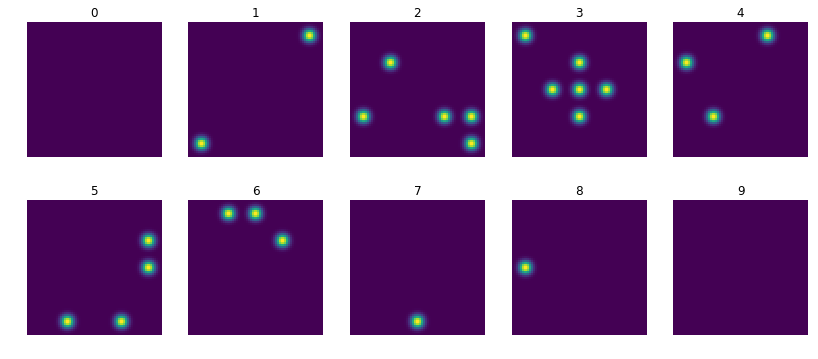

test Loss: 0.1087, Acc: 0.9918

Epoch 50/59
----------
train Loss: 0.1127, Acc: 0.9923


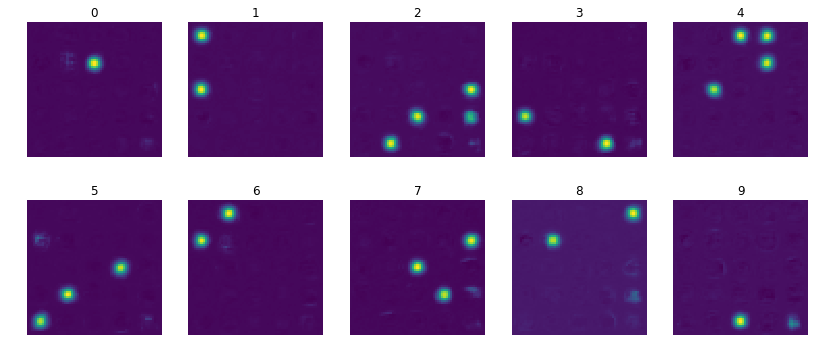

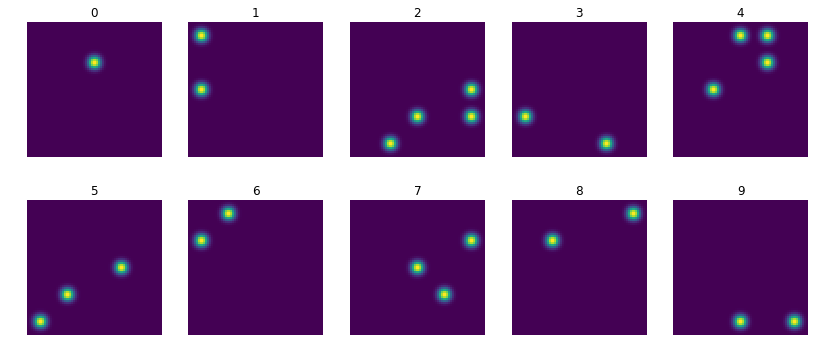

test Loss: 0.1053, Acc: 0.9919

Epoch 51/59
----------
train Loss: 0.1115, Acc: 0.9927


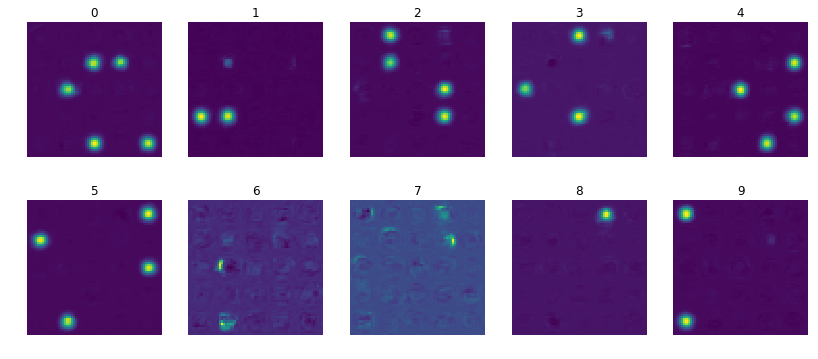

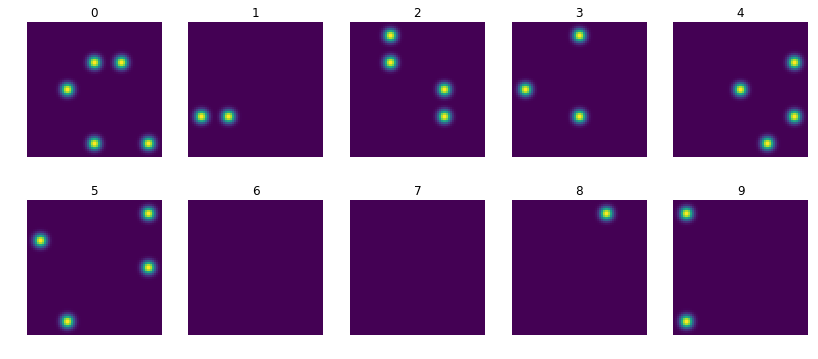

test Loss: 0.1055, Acc: 0.9919

Epoch 52/59
----------
train Loss: 0.1165, Acc: 0.9919


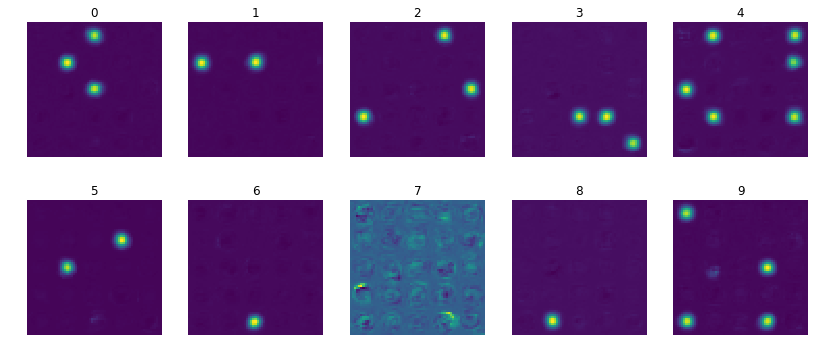

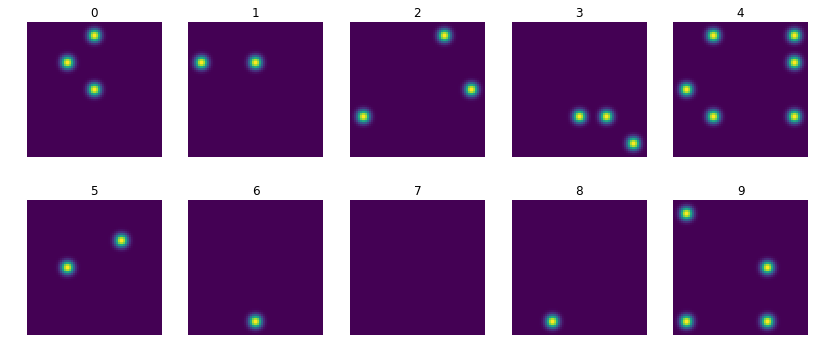

test Loss: 0.1079, Acc: 0.9924

Epoch 53/59
----------
train Loss: 0.1061, Acc: 0.9928


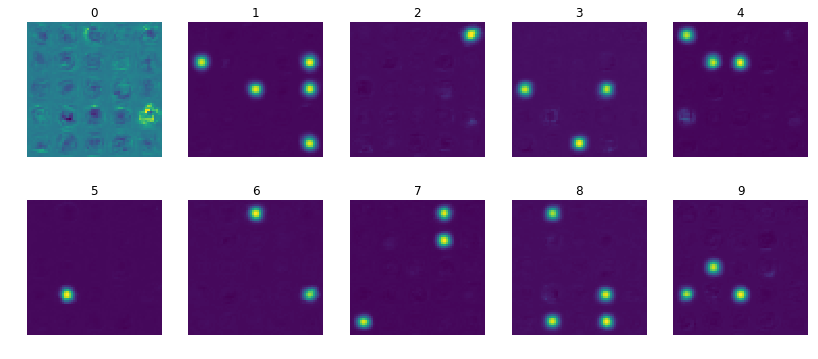

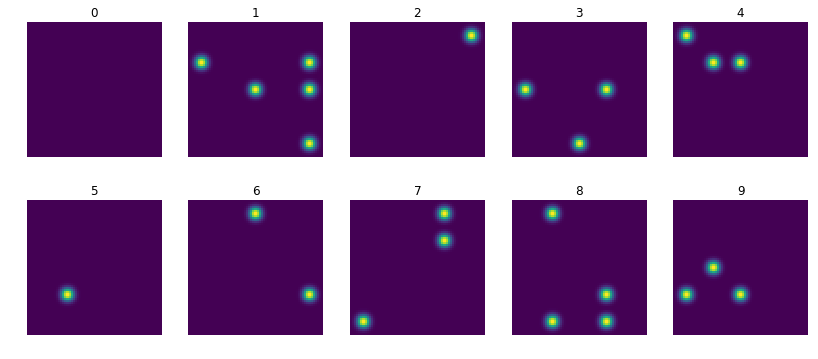

test Loss: 0.1031, Acc: 0.9917

Epoch 54/59
----------
train Loss: 0.1027, Acc: 0.9931


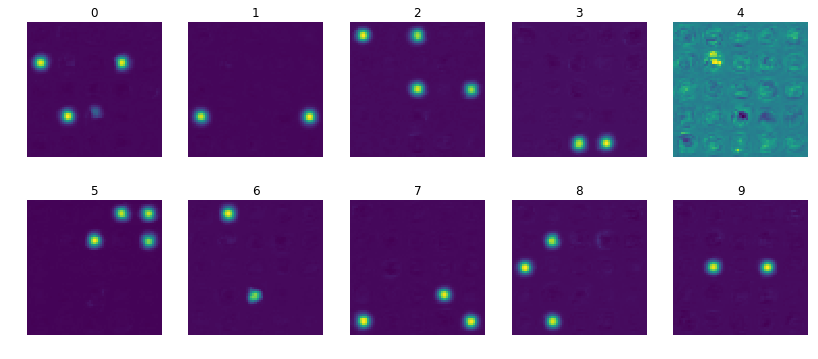

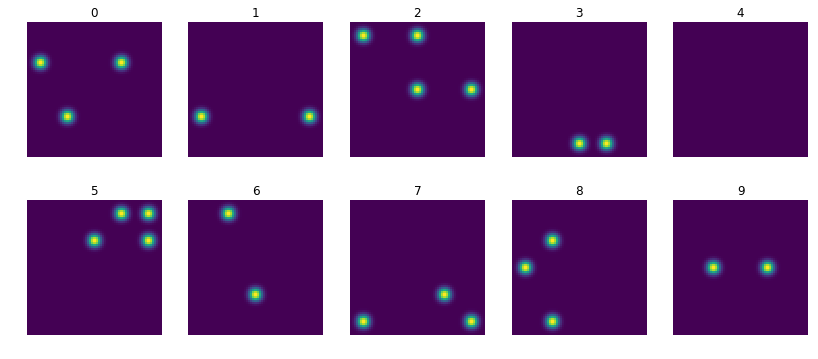

test Loss: 0.1003, Acc: 0.9910

Epoch 55/59
----------
train Loss: 0.1035, Acc: 0.9930


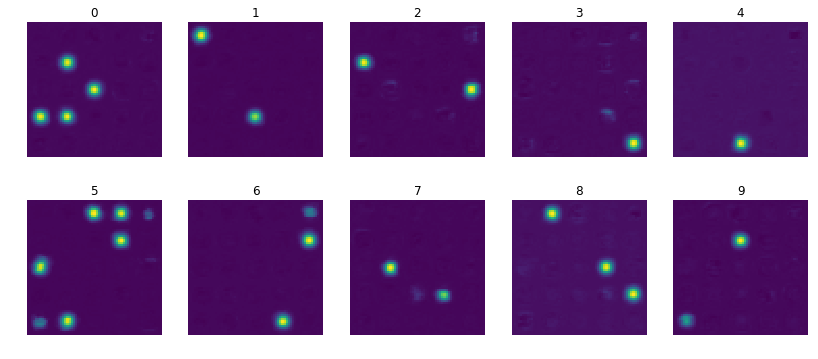

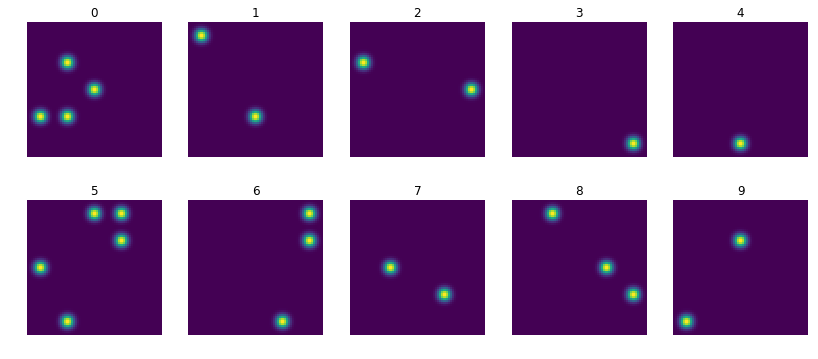

test Loss: 0.1036, Acc: 0.9907

Epoch 56/59
----------
train Loss: 0.1010, Acc: 0.9934


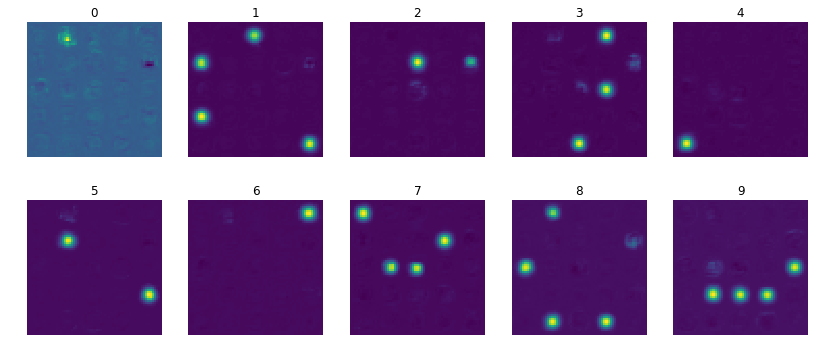

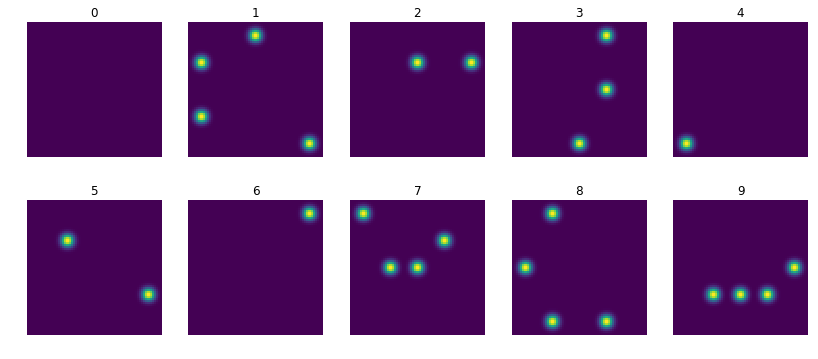

test Loss: 0.1015, Acc: 0.9928

Epoch 57/59
----------
train Loss: 0.1023, Acc: 0.9935


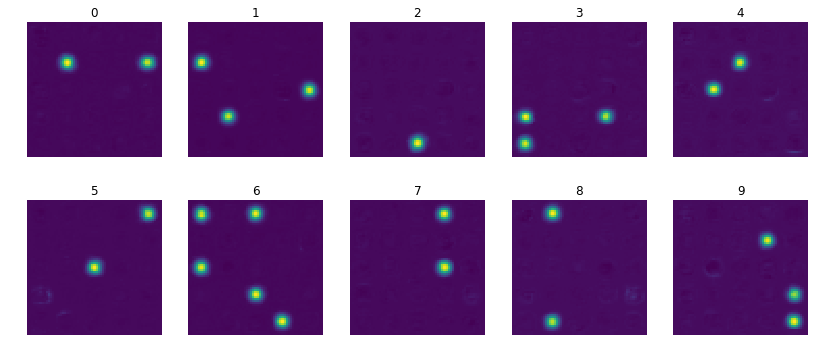

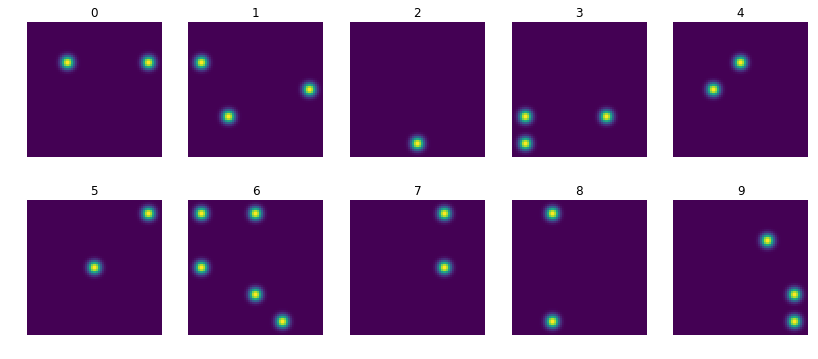

test Loss: 0.1000, Acc: 0.9918

Epoch 58/59
----------
train Loss: 0.0966, Acc: 0.9936


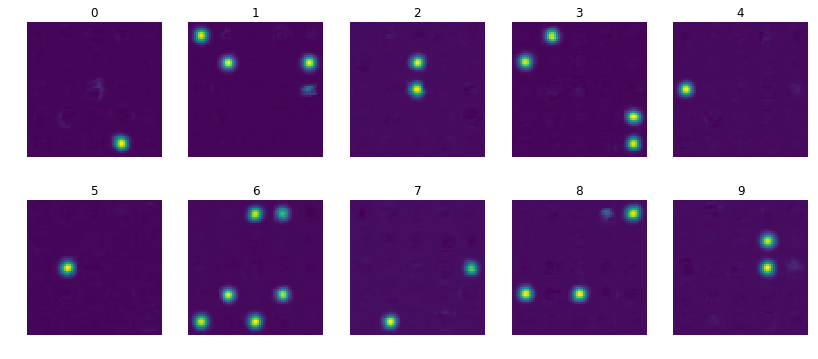

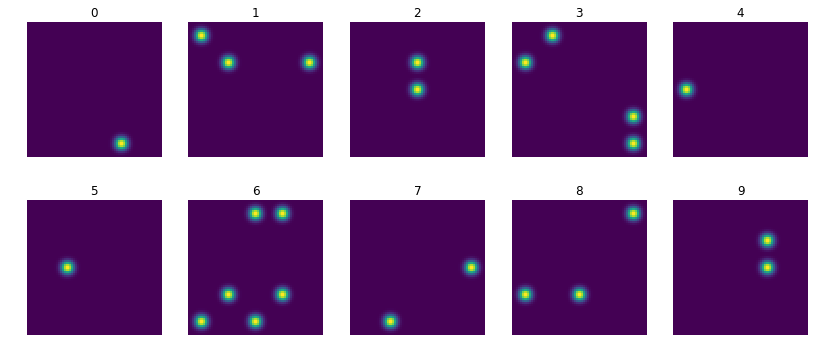

test Loss: 0.0974, Acc: 0.9915

Epoch 59/59
----------
train Loss: 0.0984, Acc: 0.9935


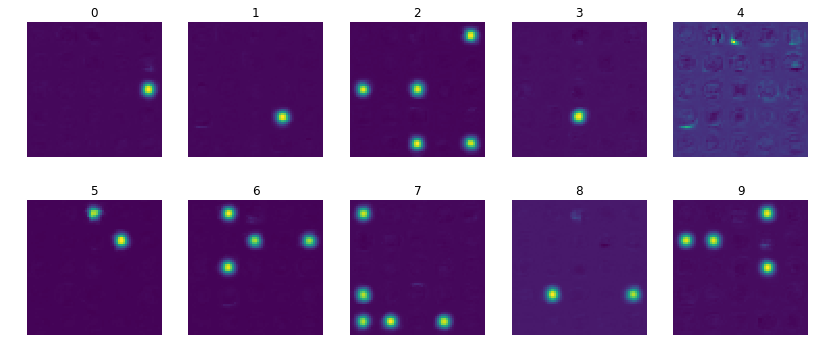

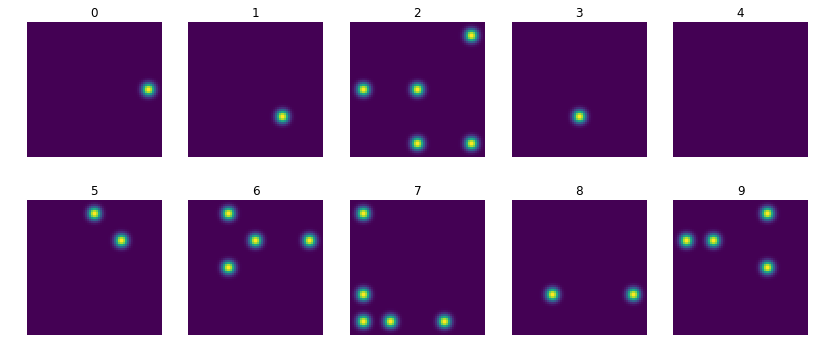

test Loss: 0.0956, Acc: 0.9918

Training complete in 45m 24s


In [20]:
from torch.optim import lr_scheduler
#params = list(e1.parameters()) + list(e2.parameters()) + list(el1.parameters())+list( el2.parameters()) + list(eb1.parameters()) +   list(eb1.parameters()) + list(autoencoder.parameters())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.cuda()
params = model.parameters()                                         
criterion = torch.nn.MSELoss()

optimizer = torch.optim.SGD(list(model.parameters()), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

import time
model_trained, res = train_model(model, criterion, optimizer,exp_lr_scheduler, num_epochs=60)

In [22]:
save_dir = '/home/oeberle/explainable_embeds/experiments/06052019_mnist_canvas/'
torch.save(model_trained.state_dict(), save_dir + 'canvasmodel.pt')

## Identifying most similar numbers across tables

In [138]:
I = np.argsort(C)

In [30]:
C = np.tensordot(A,B, [0,0] )

In [31]:
C_flat = np.reshape(C, 5*5*5*5)

In [32]:
ind = np.argsort(C_flat)[::-1]

In [33]:
inds_sorted = [np.unravel_index(i, C.shape) for i in ind]

In [35]:
X0 = X_.detach().cpu().numpy()
A0 = X0[0,:,:,:] #.shape
B0 = X0[1,:,:,:] #.shape

/home/oeberle/miniconda3/envs/tf-test/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


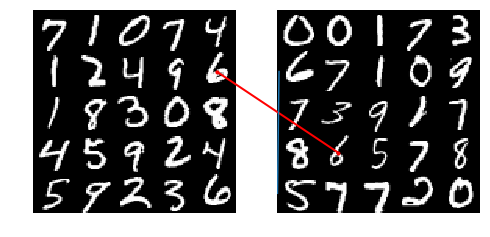

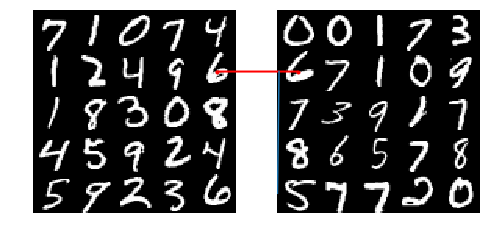

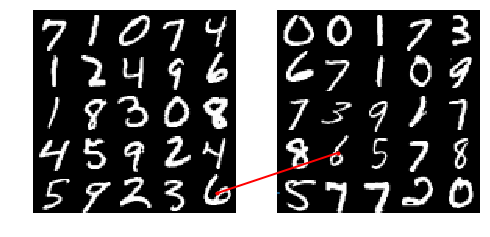

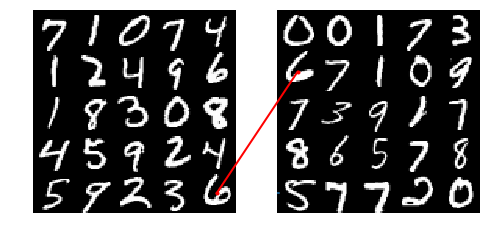

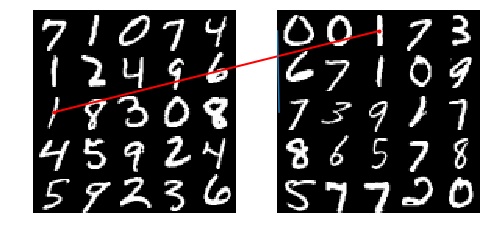

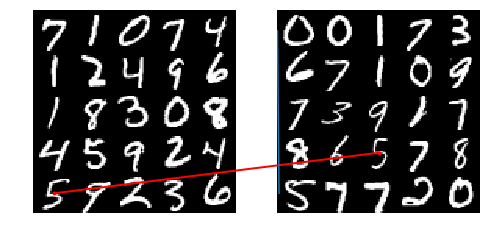

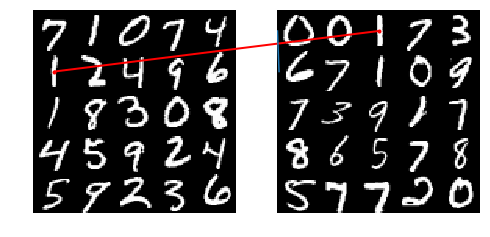

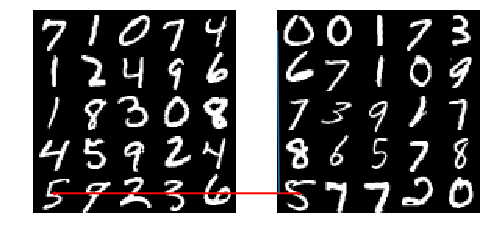

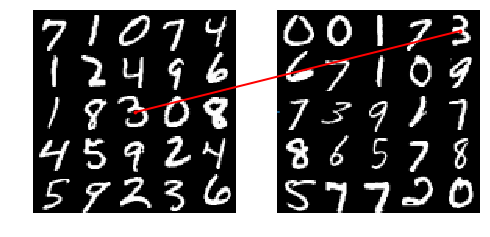

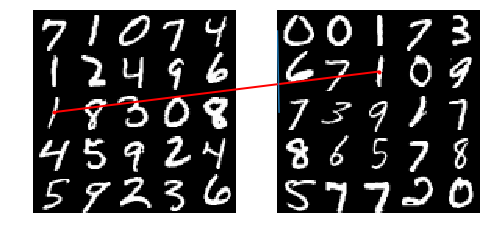

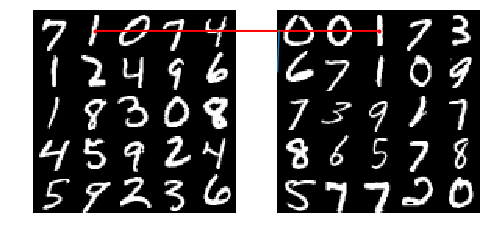

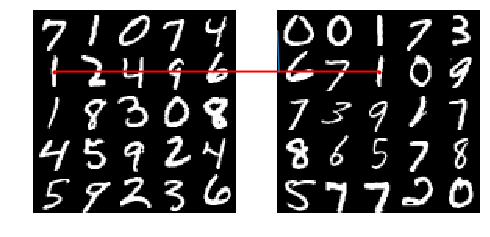

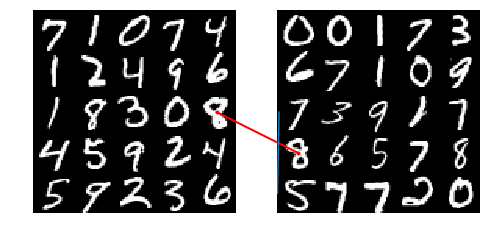

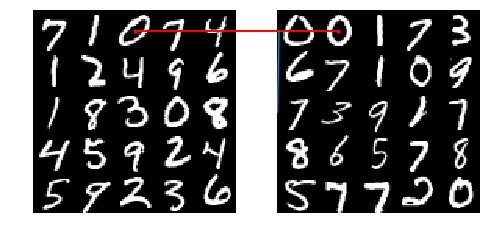

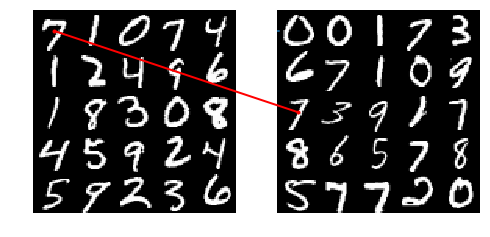

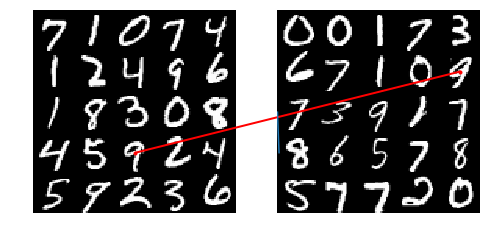

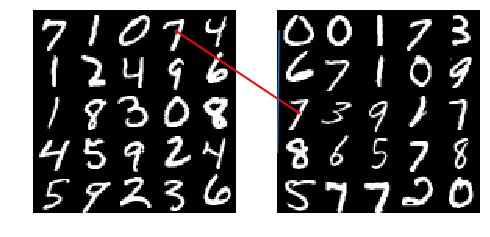

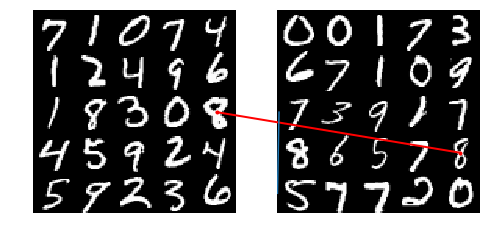

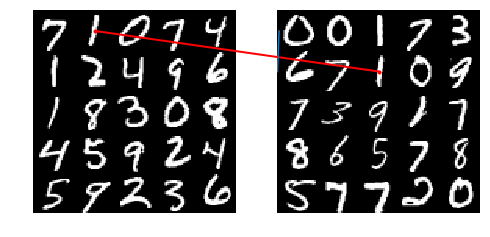

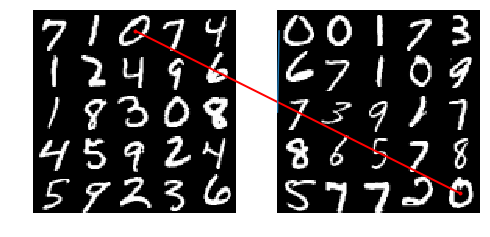

In [38]:

from matplotlib.patches import ConnectionPatch

X0 = X_.detach().cpu().numpy()
A0 = X0[0,:,:,:] #.shape
B0 = X0[1,:,:,:] #.shape


for ind in inds_sorted[:20]:
    
    f,axs = plt.subplots(1,2, figsize=(8,16))
    
    x1, y1 = 13+(ind[1])*26., 13+(ind[0])*26.    
    axs[0].imshow(A0.squeeze(), cmap = 'gray')
    axs[0].plot(x1, y1, marker = '.', color='r', markersize=6)

    x2, y2 =  13+(ind[3])*26., 13+(ind[2])*26.
    axs[1].imshow(B0.squeeze(), cmap = 'gray')
    axs[1].plot(x2,y2, marker = '.', color='r', markersize=6)
    
    
    plt.plot([x1,y1])
    
    
    con = ConnectionPatch(xyA=(x2,y2), xyB=(x1,y1), coordsA="data", coordsB="data",
                      axesA=axs[1], axesB=axs[0], color="red", linewidth=2)
    axs[1].add_artist(con)

    [ax.axis('off') for ax in axs]
    f.add_subplot(hspace=0.001, wspace=0.001)
    f.show()

## Conclusion / Limitations

- Deep CNNs can move from single digit prediction to table maps with ver high accuracy (not surprisingly)
- Network outputs are powerful to compare numbers across maps (-> duplicate detection)


- _**BUT**_:
    - Few annotated data points
    - Distractors (text, lines, images, ...)
    - Single numbers vs compositions
    - Expoited prior knowledge to compute accuracy